In [8]:
#COVID Modeling

#### Business Questions

1. What trends do we see in the spread of COVID-19, hospitalizations and deaths before and after the development of the vaccine? 

2. How effective are the vaccines in curbing the spread of the virus? 

3. What demographics are more likely to receive the vaccine in the US? 

4. Which vaccination has been administered the most globally? 

5. Percentage of people vaccinated in the US by age group.

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#classificatin models
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neural_network

#general setting for display
pd.options.display.max_rows=1000
pd.set_option('display.max_colwidth', -1)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [289]:
##################################################
#Skewed Data Transform Function - Boxcox and Log
##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

import seaborn as sns
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go throug desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1.set(xlabel='Original ' + col)
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col+'_T'] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col+'_T'] = DF[col+'_T'].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col+'_T'] = ss.boxcox(DF[col+'_T'])[0]
            skew_new = DF[col+'_T'].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col+'_T'] = make_positive(DF[col])
            
            if exp:
                #Apply exp transformation 
                DF[col+'_T'] = DF[col+'_T'].pow(10)
            else:
                #Apply boxcox transformation
                DF[col+'_T'] = ss.boxcox(DF[col+'_T'])[0]
            skew_new = DF[col+'_T'].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
            DF.drop([col], axis=1)
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                ax2 = sns.distplot(DF[col+'_T'], ax=axes[1], color = 'r')
                ax2.set(xlabel='Transformed ' + col+'_T')
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2.set(xlabel='NO TRANSFORM ' + col)
                plt.show()
                
    return DF

#Input parameters summary
#DF: Pandas DataFrame, mandatory
#threshold: skewness threshold, default value = 1, optional
#include: list of columns to process, optional
#exclude: list of columns to exclude, optional
#exp: If true, applies log / exponential transformation, the default value is False that applies Box-Cox transformation, optional

In [792]:
os.chdir('/Users/p2785388/Downloads/all_cleaned_transformed_datasets')

before_vax = pd.read_csv('before_vaccination_w_continents_dummy.csv')
after_vax = pd.read_csv('after_vaccination_w_continents_dummy.csv')
#vax_brand = pd.read_csv('vaccines_by_manufacturer.csv')

#### 1. Question 1: Data Understanding. 
#### Explore the basic information of the datasets

In [492]:
after_vax.T

0           1           2  \
date                                     2020-12-01  2020-12-01  2020-12-01   
total_cases                              285489.0    5854.0      8710.0       
new_cases                                3033.0      0.0         109.0        
new_cases_smoothed                       4397.0      74.143      73.857       
total_deaths                             3325.0      148.0       177.0        
new_deaths                               141.0       0.0         0.0          
new_deaths_smoothed                      106.857     3.286       1.143        
total_cases_per_million                  31569.913   14457.355   1824.042     
new_cases_per_million                    335.395     0.0         22.827       
new_cases_smoothed_per_million           486.229     183.107     15.467       
total_deaths_per_million                 367.685     365.509     37.067       
new_deaths_per_million                   15.592      0.0         0.0          
new_deaths_smoothed_per_million          11.816      8.115       0.239        
reproduction_rate                        0.77        0.91        1.77         
icu_patients                             691.0       0.0         0.0          
icu_patients_per_million                 76.412      0.0         0.0          
hosp_patients                            3791.0      0.0         0.0          
hosp_patients_per_million                419.216     0.0         0.0          
weekly_icu_admissions                    0.0         0.0         0.0          
weekly_icu_admissions_per_million        0.0         0.0         0.0          
weekly_hosp_admissions                   0.0         0.0         0.0          
weekly_hosp_admissions_per_million       0.0         0.0         0.0          
new_tests                                23192.0     0.0         746.0        
total_tests                              3121510.0   0.0         104875.0     
total_tests_per_thousand                 345.182     0.0         21.963       
new_tests_per_thousand                   2.565       0.0         0.156        
new_tests_smoothed                       27369.0     0.0         689.0        
new_tests_smoothed_per_thousand          3.027       0.0         0.144        
positive_rate                            0.0         0.0         0.0          
tests_per_case                           0.0         0.0         0.0          
total_vaccinations                       0.0         0.0         0.0          
people_vaccinated                        0.0         0.0         0.0          
people_fully_vaccinated                  0.0         0.0         0.0          
total_boosters                           0.0         0.0         0.0          
new_vaccinations                         0.0         0.0         0.0          
new_vaccinations_smoothed                0.0         0.0         0.0          
total_vaccinations_per_hundred           0.0         0.0         0.0          
people_vaccinated_per_hundred            0.0         0.0         0.0          
people_fully_vaccinated_per_hundred      0.0         0.0         0.0          
total_boosters_per_hundred               0.0         0.0         0.0          
new_vaccinations_smoothed_per_million    0.0         0.0         0.0          
stringency_index                         82.41       72.22       21.3         
population                               9043072.0   404915.0    4775110.0    
population_density                       106.749     16.426      4.289        
median_age                               44.4        25.0        20.3         
aged_65_older                            19.202      3.853       3.138        
aged_70_older                            13.748      2.279       1.792        
gdp_per_capita                           45436.686   7824.362    3597.633     
extreme_poverty                          0.7         0.0         6.0          
cardiovasc_death_rate                    145.183     176.957     232.347      
diabetes_prevalence  

In [12]:
#shape, columns, type of each dataset
print(before_vax.info())
print()
print(after_vax.info())
print()
#print(vax_brand.info())
print()

#describe each dataset
print(before_vax.describe())
print()
print(after_vax.describe())
print()
#print(vax_brand.describe())

#first 5 rows of each dataset
print(before_vax.head())
print()
print(after_vax.head())
print()
#print(vax_brand.head())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53381 entries, 0 to 53380
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   date                                     53381 non-null  object 
 1   total_cases                              53381 non-null  float64
 2   new_cases                                53381 non-null  float64
 3   new_cases_smoothed                       53381 non-null  float64
 4   total_deaths                             53381 non-null  float64
 5   new_deaths                               53381 non-null  float64
 6   new_deaths_smoothed                      53381 non-null  float64
 7   total_cases_per_million                  53381 non-null  float64
 8   new_cases_per_million                    53381 non-null  float64
 9   new_cases_smoothed_per_million           53381 non-null  float64
 10  total_deaths_per_million                 53381

        total_cases      new_cases  new_cases_smoothed  total_deaths  \
count  6.213700e+04  62137.000000   62137.000000        6.213700e+04   
mean   2.413284e+06  8759.489258    8780.241866         5.231542e+04   
std    1.292886e+07  48483.324016   47932.194878        2.749584e+05   
min    1.000000e+00 -74347.000000  -6223.000000         0.000000e+00   
25%    1.075500e+04  7.000000       22.429000           1.440000e+02   
50%    9.418800e+04  197.000000     245.714000          1.357000e+03   
75%    4.481580e+05  1458.000000    1511.857000         8.716000e+03   
max    2.363392e+08  905948.000000  826439.429000       4.826062e+06   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  62137.000000  62137.000000         62137.000000              
mean   167.120331    167.517195           30091.617556              
std    911.939903    892.999232           36587.769903              
min   -679.000000   -1.571000             0.000000                  
25%   

#### Step 2: Data Cleaning and Preprocessing. 
#### Clean and preprocess the datasets (such as missing values, outliers, dummy, merging etc.)

In [791]:
###########################
#check for NaN values in each dataset
###########################

print("before vax: ", before_vax.isnull().sum().sum())
print("after vax: ", after_vax.isnull().sum().sum())
#print("vax brand: ", vax_brand.isnull().sum().sum())
print()

before vax:  0
after vax:  0



### Step 3: Data Cleaning for Each Dataset

In [14]:
###########################
#detect skewness, colinearity, and adjust outliers
###########################

In [15]:
#Correlation of Features for the After Vaccine Rollout Dataset
after_vax.corr()

total_cases  new_cases  \
total_cases                              1.000000     0.863494    
new_cases                                0.863494     1.000000    
new_cases_smoothed                       0.877849     0.986125    
total_deaths                             0.990024     0.854644    
new_deaths                               0.839742     0.948272    
new_deaths_smoothed                      0.862180     0.940265    
total_cases_per_million                  0.072692     0.032739    
new_cases_per_million                    0.013749     0.063224    
new_cases_smoothed_per_million           0.017464     0.060264    
total_deaths_per_million                 0.106725     0.060150    
new_deaths_per_million                   0.023308     0.057530    
new_deaths_smoothed_per_million          0.031557     0.064837    
reproduction_rate                       -0.123181    -0.107236    
icu_patients                             0.126660     0.157653    
icu_patients_per_million                 0.014225     0.031559    
hosp_patients                            0.112827     0.151665    
hosp_patients_per_million               -0.009980     0.006218    
weekly_icu_admissions                    0.000076     0.002174    
weekly_icu_admissions_per_million       -0.006483    -0.005623    
weekly_hosp_admissions                   0.047027     0.038466    
weekly_hosp_admissions_per_million       0.002130     0.001669    
new_tests                                0.152232     0.164956    
total_tests                              0.181595     0.136518    
total_tests_per_thousand                -0.028126    -0.032791    
new_tests_per_thousand                  -0.027296    -0.024958    
new_tests_smoothed                       0.156739     0.164142    
new_tests_smoothed_per_thousand         -0.035314    -0.033079    
positive_rate                           -0.061515    -0.029872    
tests_per_case                          -0.021363    -0.022621    
total_vaccinations                       0.784896     0.573057    
people_vaccinated                        0.819379     0.588095    
people_fully_vaccinated                  0.748930     0.519120    
total_boosters                           0.544989     0.360972    
new_vaccinations                         0.800523     0.661605    
new_vaccinations_smoothed                0.814375     0.659536    
total_vaccinations_per_hundred           0.130595     0.057453    
people_vaccinated_per_hundred            0.139755     0.060750    
people_fully_vaccinated_per_hundred      0.111530     0.041868    
total_boosters_per_hundred               0.006351     0.002011    
new_vaccinations_smoothed_per_million    0.073618     0.030920    
stringency_index                        -0.199535    -0.182194    
population                               0.853365     0.852601    
population_density                      -0.030188    -0.028915    
median_age                              -0.104284    -0.100420    
aged_65_older                           -0.036378    -0.037626    
aged_70_older                           -0.036403    -0.037928    
gdp_per_capita                          -0.032092    -0.034700    
extreme_poverty                         -0.043482    -0.041239    
cardiovasc_death_rate                   -0.145211    -0.136927    
diabetes_prevalence                     -0.087079    -0.082666    
female_smokers                          -0.021333    -0.025071    
male_smokers                            -0.035432    -0.029733    
handwashing_facilities                   0.004214     0.010180    
hospital_beds_per_thousand              -0.053495    -0.052134    
life_expectancy                         -0.253333    -0.241780    
human_development_index                 -0.147006    -0.141018    
excess_mortality_cumulative_absolute     0.039396     0.017007    
excess_mortality_cumulative             -0.002789    -0.006841    
excess_mortality                        -0.005106    -0.001296    
excess_mortality_cumu

In [16]:
after_vax_highCorr = after_vax.drop(['date'], axis=1)

def get_redundant_pairs(after_vax_highCorr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = after_vax_highCorr.columns
    for i in range(0, after_vax_highCorr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(after_vax_highCorr, n=10):
    au_corr = after_vax_highCorr.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(after_vax_highCorr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations:")
print()
list_corr = get_top_abs_correlations(after_vax_highCorr)
print(get_top_abs_correlations(after_vax_highCorr, 25))

Top Absolute Correlations:

total_cases                     total_deaths                               0.990024
new_cases                       new_cases_smoothed                         0.986125
new_vaccinations                new_vaccinations_smoothed                  0.981753
new_deaths                      new_deaths_smoothed                        0.977129
aged_65_older                   aged_70_older                              0.966561
new_cases_smoothed              new_deaths_smoothed                        0.958663
total_vaccinations              people_vaccinated                          0.952787
new_tests                       new_tests_smoothed                         0.951657
people_vaccinated               people_fully_vaccinated                    0.949473
new_cases                       new_deaths                                 0.948272
total_vaccinations_per_hundred  people_vaccinated_per_hundred              0.944253
new_cases_smoothed              new_deaths      

Skew AFTER Transform:
total_cases                                10.982123
new_cases                                  10.279626
new_cases_smoothed                         10.077248
total_deaths                               10.910948
new_deaths                                 10.301086
new_deaths_smoothed                        9.867136 
total_cases_per_million                    1.534302 
new_cases_per_million                      5.423362 
new_cases_smoothed_per_million             3.627918 
total_deaths_per_million                   2.123739 
new_deaths_per_million                     9.078775 
new_deaths_smoothed_per_million            4.313778 
reproduction_rate                         -0.708064 
icu_patients                               16.002244
icu_patients_per_million                   5.131077 
hosp_patients                              13.971399
hosp_patients_per_million                  5.748868 
weekly_icu_admissions                      32.931660
weekly_icu_admissions_pe

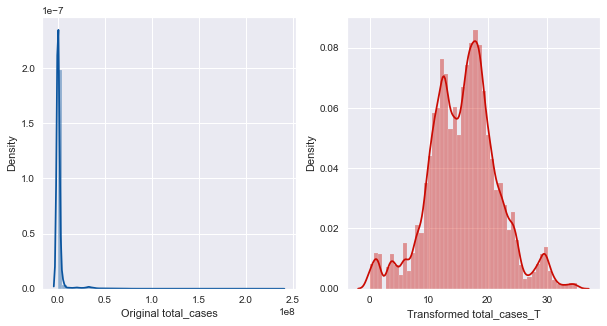


 ------------------------------------------------------

 'new_cases' had 'positive' skewness of 10.28

 Transformation yielded skewness of -0.29


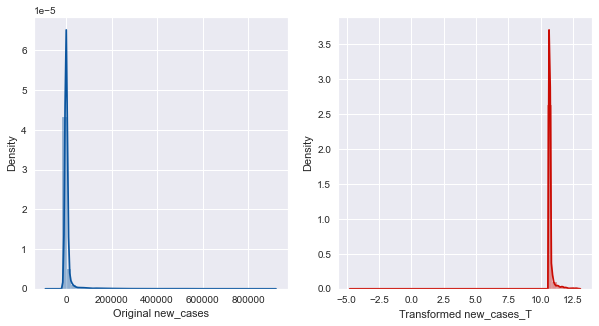


 ------------------------------------------------------

 'new_cases_smoothed' had 'positive' skewness of 10.08

 Transformation yielded skewness of -5.03


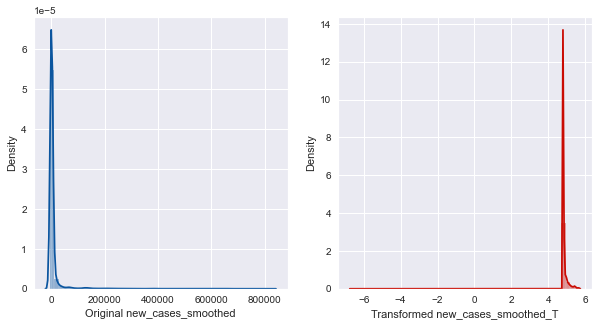


 ------------------------------------------------------

 'total_deaths' had 'positive' skewness of 10.91

 Transformation yielded skewness of 0.04


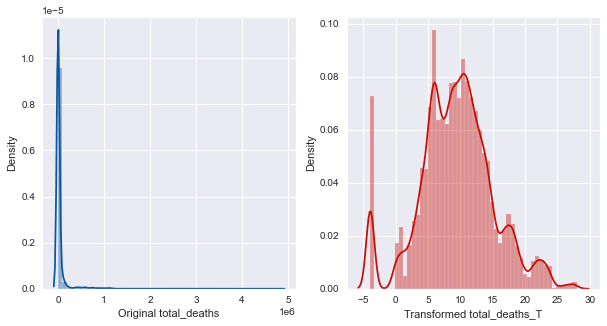


 ------------------------------------------------------

 'new_deaths' had 'positive' skewness of 10.30

 Transformation yielded skewness of -3.99


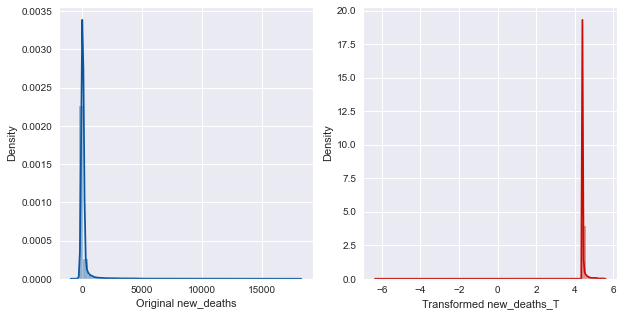


 ------------------------------------------------------

 'new_deaths_smoothed' had 'positive' skewness of 9.87

 Transformation yielded skewness of 0.17


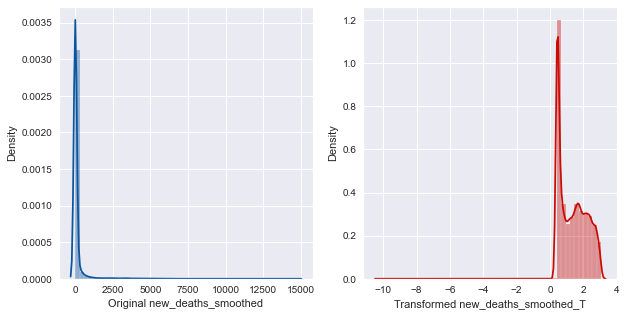


 ------------------------------------------------------

 'total_cases_per_million' had 'positive' skewness of 1.53

 Transformation yielded skewness of -0.18


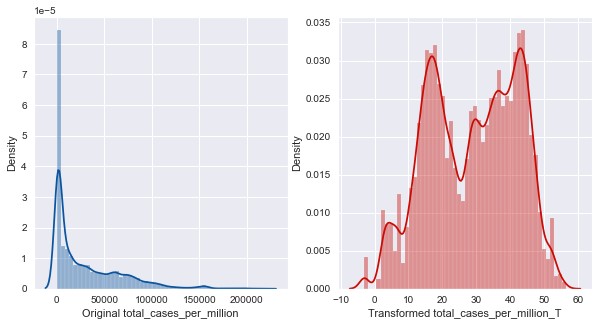


 ------------------------------------------------------

 'new_cases_per_million' had 'positive' skewness of 5.42

 Transformation yielded skewness of 1.92


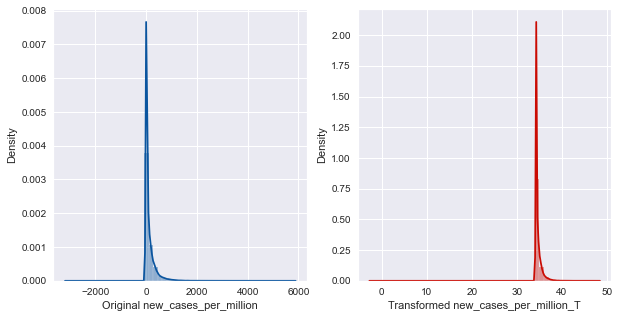


 ------------------------------------------------------

 'new_cases_smoothed_per_million' had 'positive' skewness of 3.63

 Transformation yielded skewness of -1.06


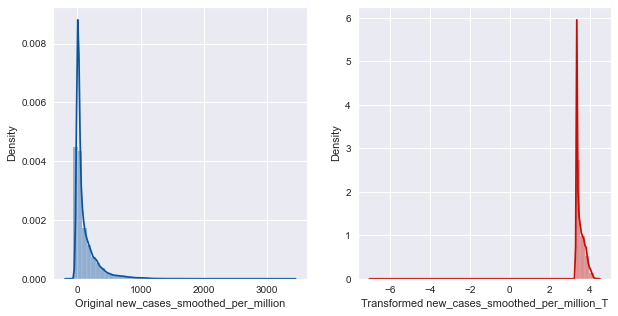


 ------------------------------------------------------

 'total_deaths_per_million' had 'positive' skewness of 2.12

 Transformation yielded skewness of -0.19


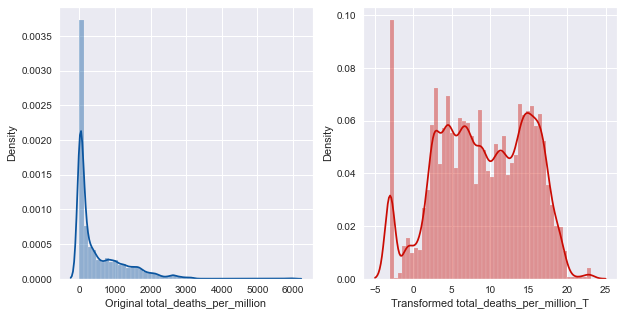


 ------------------------------------------------------

 'new_deaths_per_million' had 'positive' skewness of 9.08

 Transformation yielded skewness of -0.35


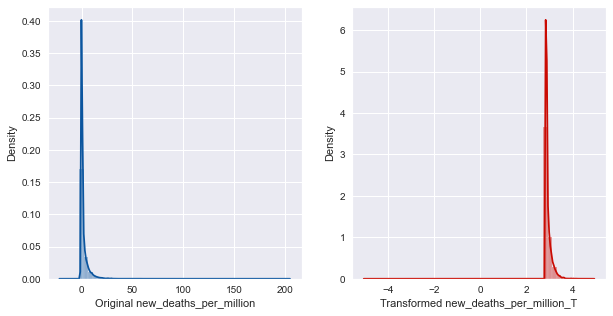


 ------------------------------------------------------

 'new_deaths_smoothed_per_million' had 'positive' skewness of 4.31

 Transformation yielded skewness of -1.77


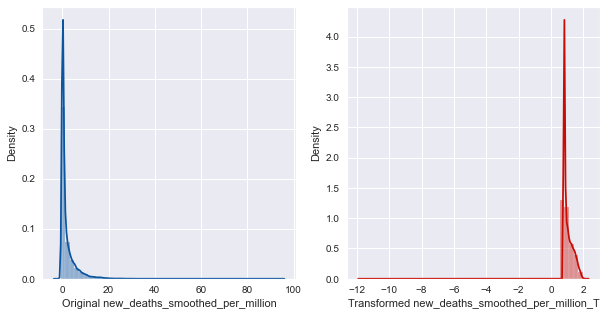


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'reproduction_rate' . Skewness = -0.71


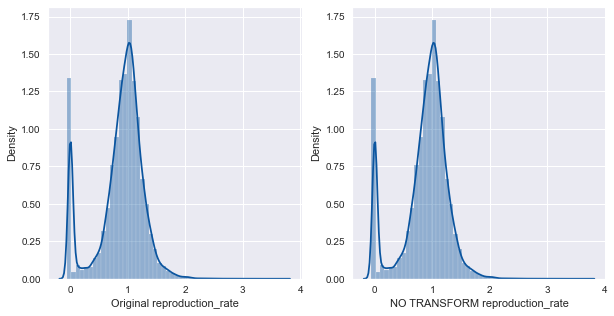


 ------------------------------------------------------

 'icu_patients' had 'positive' skewness of 16.00

 Transformation yielded skewness of 2.22


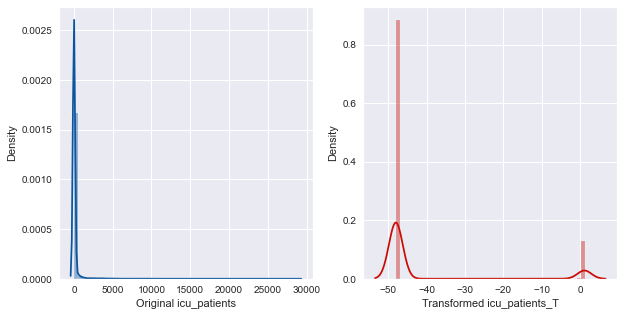


 ------------------------------------------------------

 'icu_patients_per_million' had 'positive' skewness of 5.13

 Transformation yielded skewness of 2.22


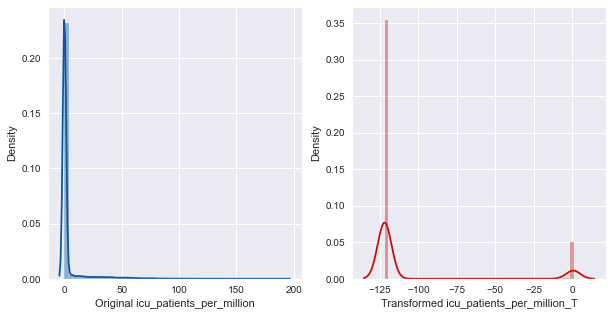


 ------------------------------------------------------

 'hosp_patients' had 'positive' skewness of 13.97

 Transformation yielded skewness of 2.00


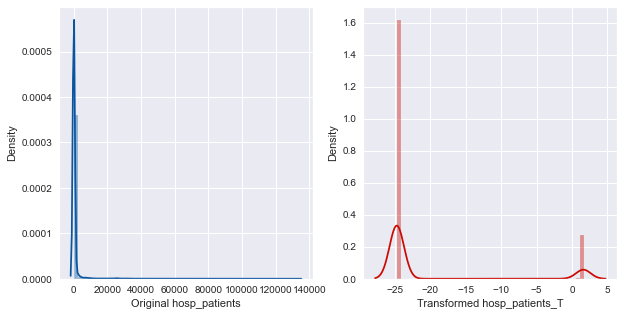


 ------------------------------------------------------

 'hosp_patients_per_million' had 'positive' skewness of 5.75

 Transformation yielded skewness of 2.00


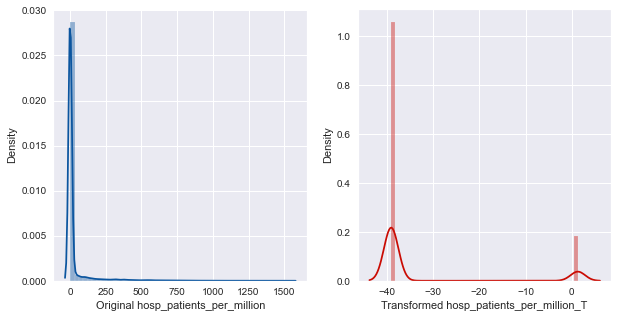


 ------------------------------------------------------

 'weekly_icu_admissions' had 'positive' skewness of 32.93

 Transformation yielded skewness of 9.32


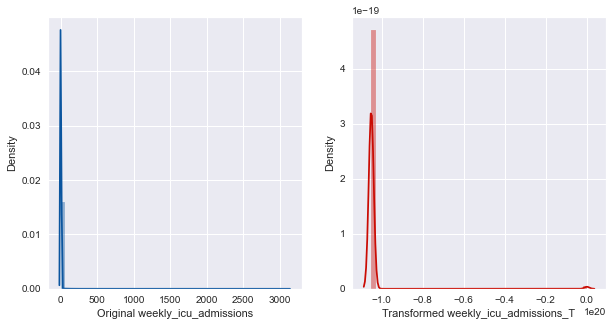


 ------------------------------------------------------

 'weekly_icu_admissions_per_million' had 'positive' skewness of 34.54

 Transformation yielded skewness of 9.32


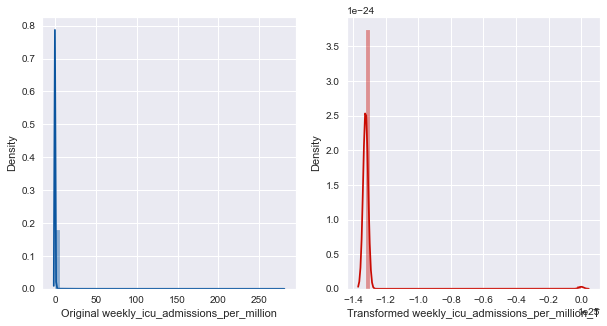


 ------------------------------------------------------

 'weekly_hosp_admissions' had 'positive' skewness of 45.54

 Transformation yielded skewness of 7.26


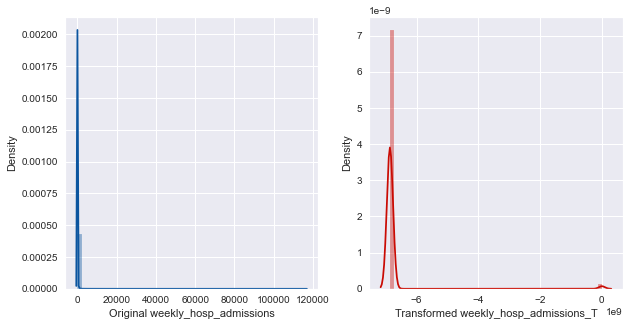


 ------------------------------------------------------

 'weekly_hosp_admissions_per_million' had 'positive' skewness of 27.36

 Transformation yielded skewness of 7.26


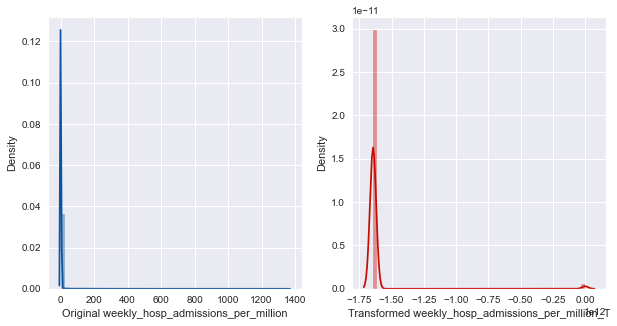


 ------------------------------------------------------

 'new_tests' had 'positive' skewness of 8.92

 Transformation yielded skewness of 0.27


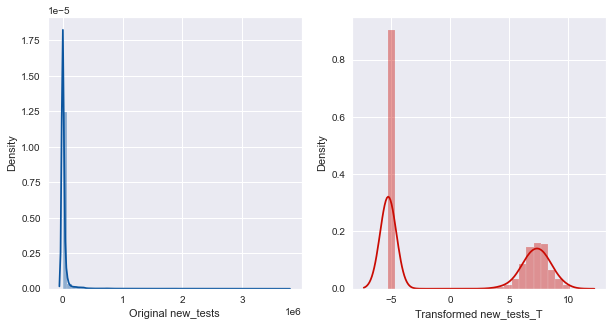


 ------------------------------------------------------

 'total_tests' had 'positive' skewness of 9.34

 Transformation yielded skewness of 0.24


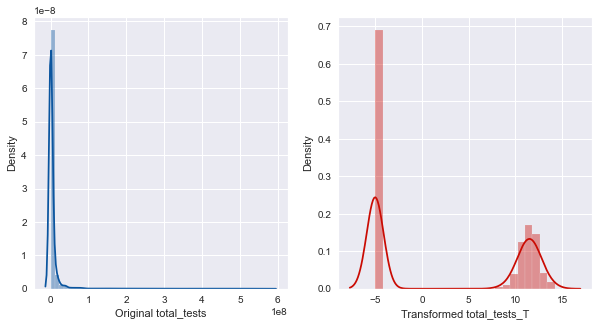


 ------------------------------------------------------

 'total_tests_per_thousand' had 'positive' skewness of 6.27

 Transformation yielded skewness of 0.27


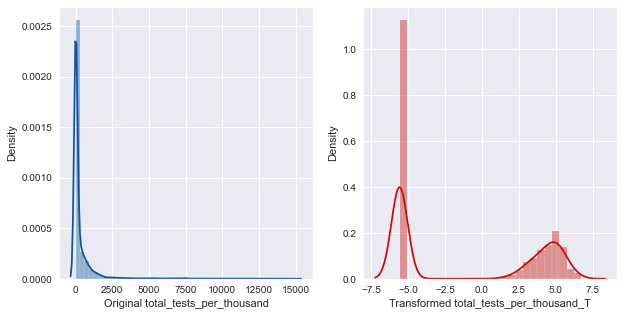


 ------------------------------------------------------

 'new_tests_per_thousand' had 'positive' skewness of 10.89

 Transformation yielded skewness of 0.40


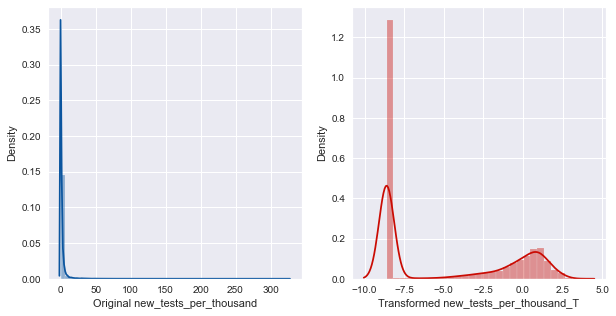


 ------------------------------------------------------

 'new_tests_smoothed' had 'positive' skewness of 8.21

 Transformation yielded skewness of -0.09


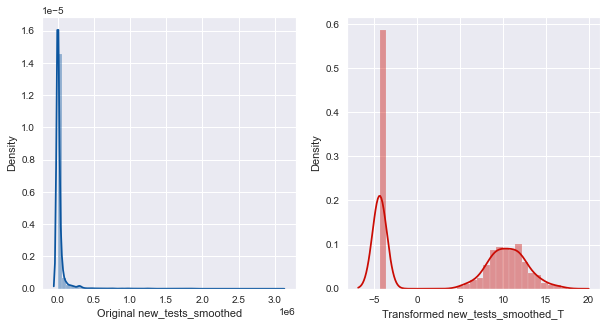


 ------------------------------------------------------

 'new_tests_smoothed_per_thousand' had 'positive' skewness of 7.06

 Transformation yielded skewness of 0.13


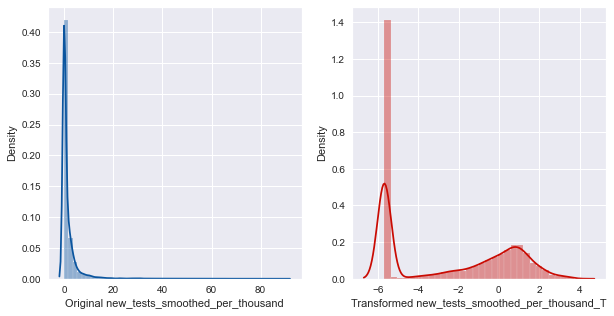


 ------------------------------------------------------

 'positive_rate' had 'positive' skewness of 2.26

 Transformation yielded skewness of 0.36


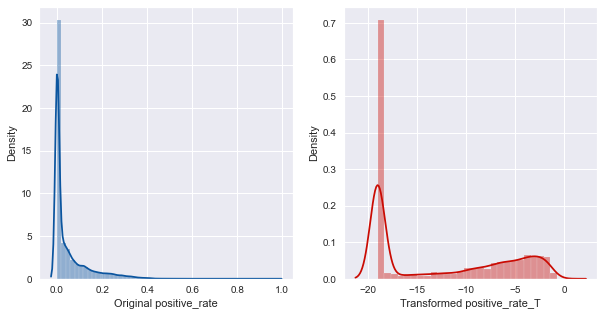


 ------------------------------------------------------

 'tests_per_case' had 'positive' skewness of 24.26

 Transformation yielded skewness of 0.07


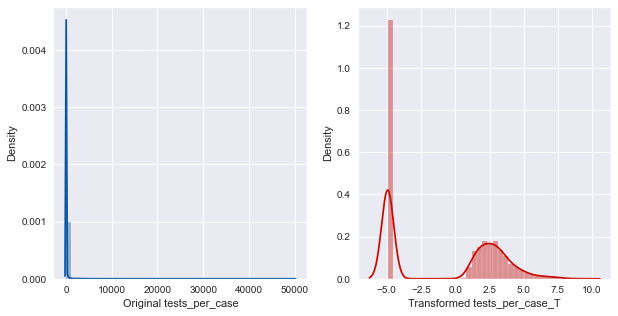


 ------------------------------------------------------

 'total_vaccinations' had 'positive' skewness of 15.05

 Transformation yielded skewness of 0.34


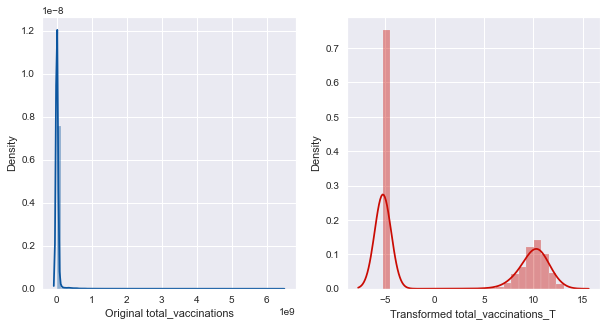


 ------------------------------------------------------

 'people_vaccinated' had 'positive' skewness of 16.66

 Transformation yielded skewness of 0.41


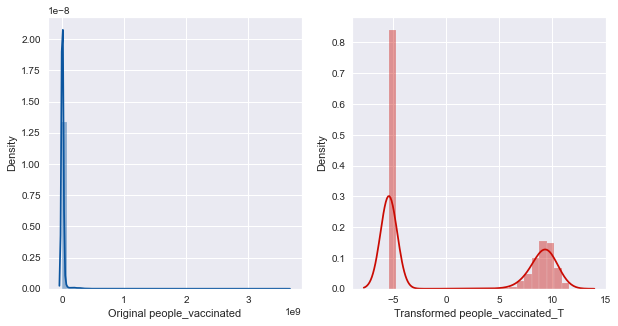


 ------------------------------------------------------

 'people_fully_vaccinated' had 'positive' skewness of 20.34

 Transformation yielded skewness of 0.61


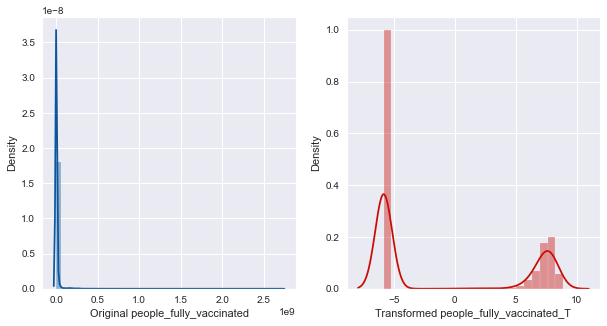


 ------------------------------------------------------

 'total_boosters' had 'positive' skewness of 21.68

 Transformation yielded skewness of 4.17


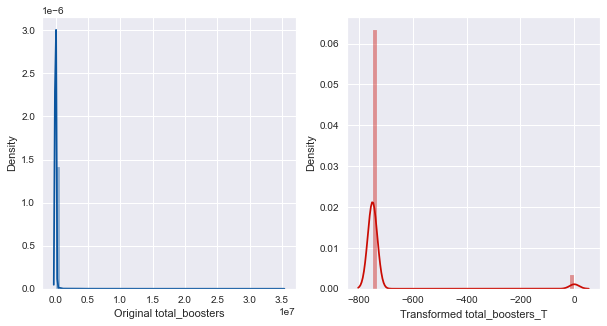


 ------------------------------------------------------

 'new_vaccinations' had 'positive' skewness of 12.46

 Transformation yielded skewness of 0.62


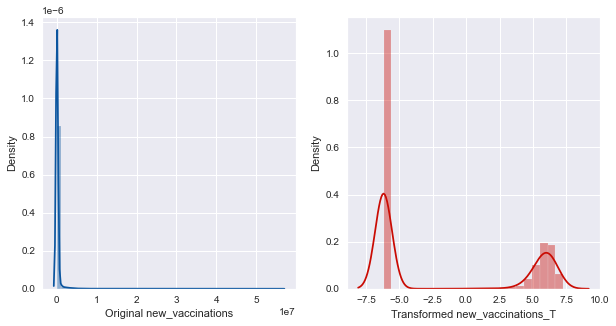


 ------------------------------------------------------

 'new_vaccinations_smoothed' had 'positive' skewness of 12.19

 Transformation yielded skewness of -0.18


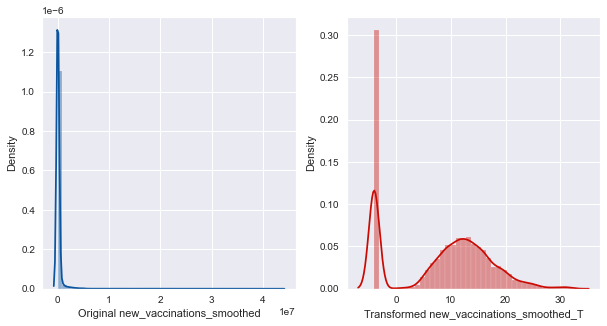


 ------------------------------------------------------

 'total_vaccinations_per_hundred' had 'positive' skewness of 2.20

 Transformation yielded skewness of 0.42


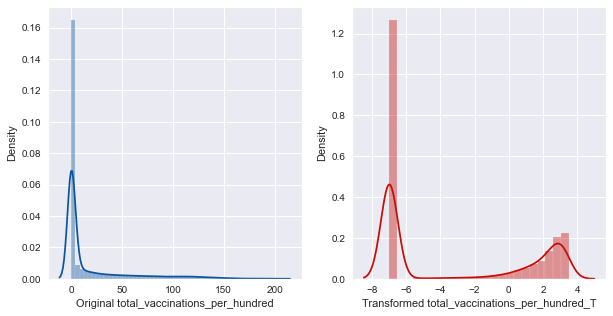


 ------------------------------------------------------

 'people_vaccinated_per_hundred' had 'positive' skewness of 1.96

 Transformation yielded skewness of 0.49


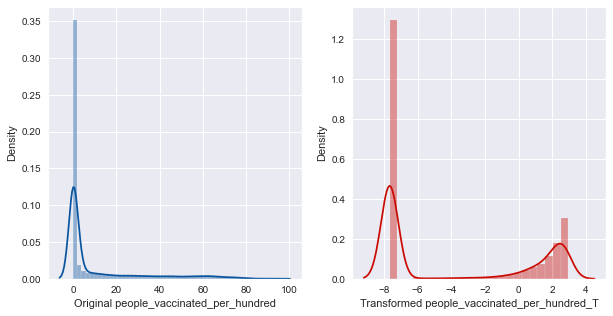


 ------------------------------------------------------

 'people_fully_vaccinated_per_hundred' had 'positive' skewness of 2.60

 Transformation yielded skewness of 0.70


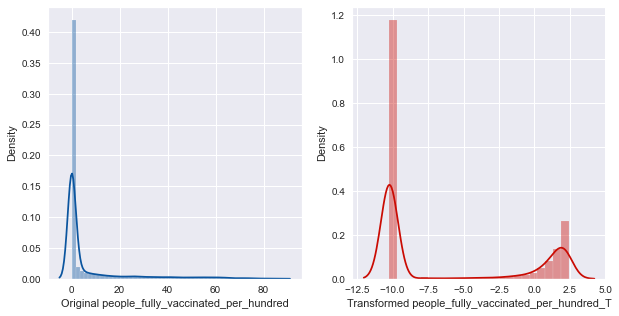


 ------------------------------------------------------

 'total_boosters_per_hundred' had 'positive' skewness of 20.82

 Transformation yielded skewness of 5.68


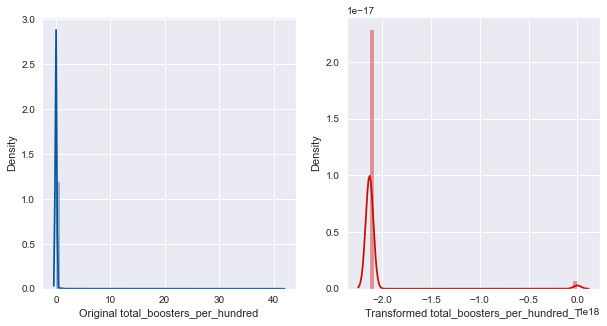


 ------------------------------------------------------

 'new_vaccinations_smoothed_per_million' had 'positive' skewness of 5.44

 Transformation yielded skewness of -0.41


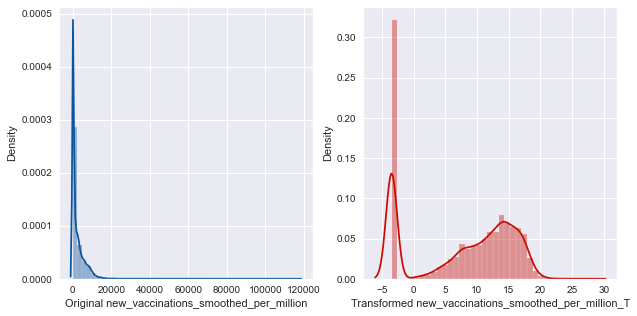


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'stringency_index' . Skewness = -0.54


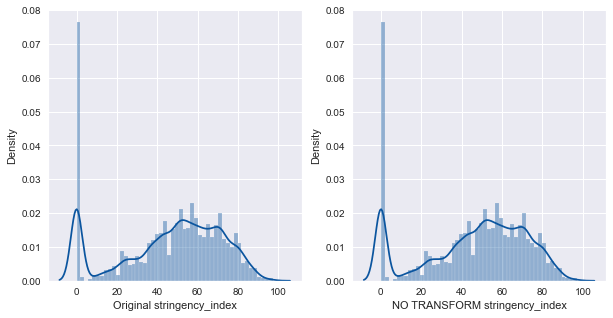


 ------------------------------------------------------

 'population' had 'positive' skewness of 9.60

 Transformation yielded skewness of 0.18


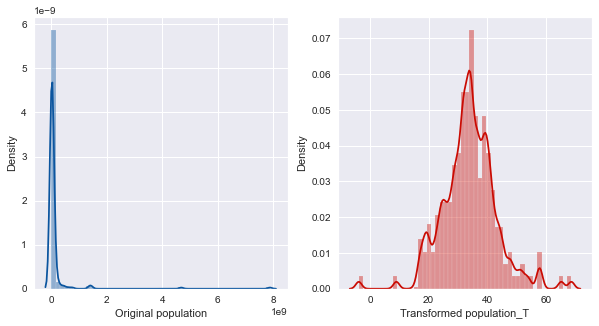


 ------------------------------------------------------

 'population_density' had 'positive' skewness of 10.20

 Transformation yielded skewness of 0.26


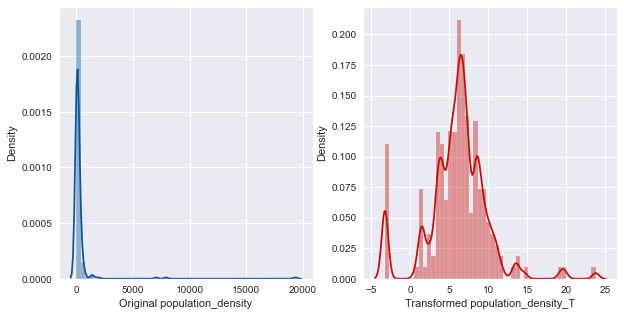


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'median_age' . Skewness = -0.60


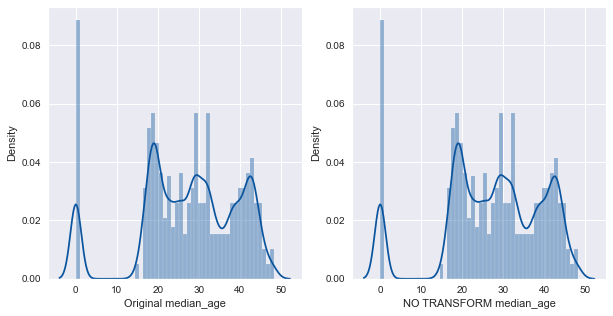


 ------------------------------------------------------

 'aged_65_older' had 'positive' skewness of 0.84

 Transformation yielded skewness of -0.27


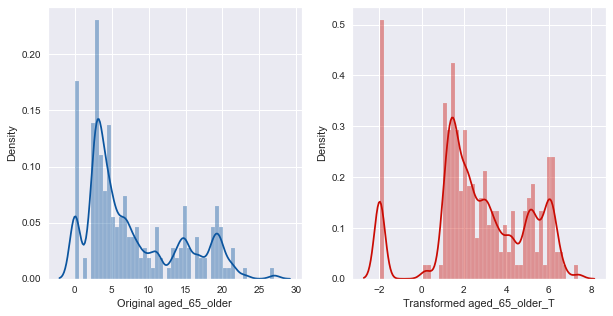


 ------------------------------------------------------

 'aged_70_older' had 'positive' skewness of 0.99

 Transformation yielded skewness of -0.19


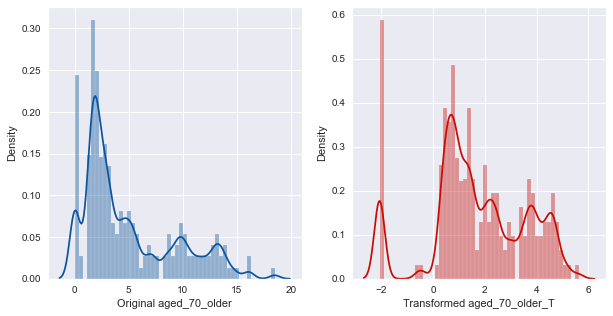


 ------------------------------------------------------

 'gdp_per_capita' had 'positive' skewness of 1.92

 Transformation yielded skewness of -0.40


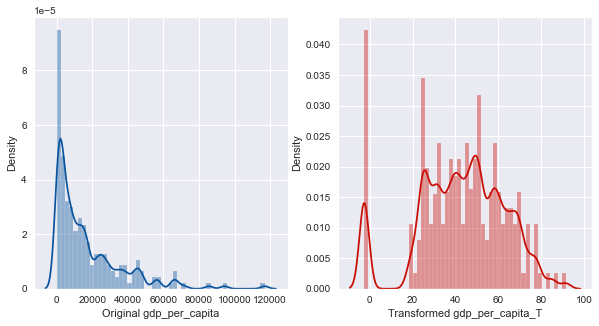


 ------------------------------------------------------

 'extreme_poverty' had 'positive' skewness of 2.31

 Transformation yielded skewness of 0.06


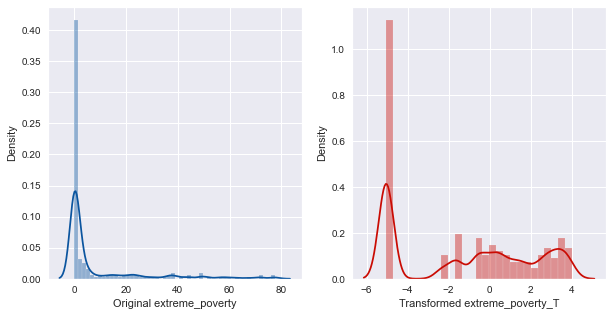


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'cardiovasc_death_rate' . Skewness = 0.43


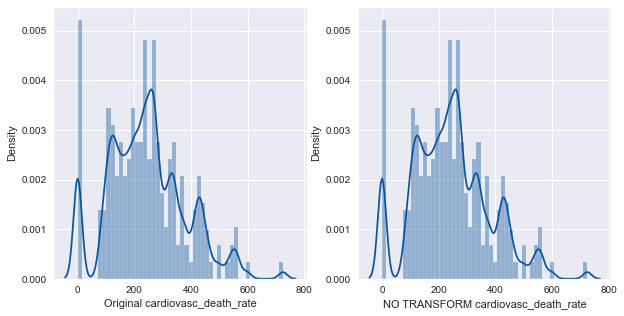


 ------------------------------------------------------

 'diabetes_prevalence' had 'positive' skewness of 1.14

 Transformation yielded skewness of -0.17


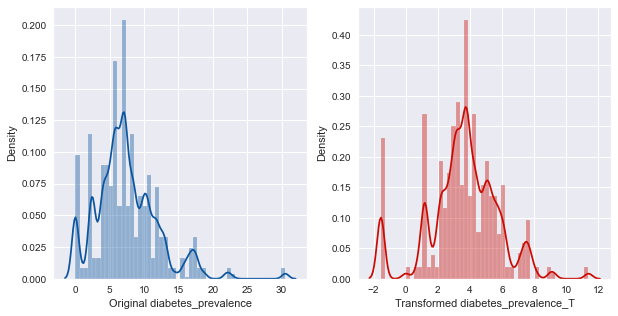


 ------------------------------------------------------

 'female_smokers' had 'positive' skewness of 1.40

 Transformation yielded skewness of -0.22


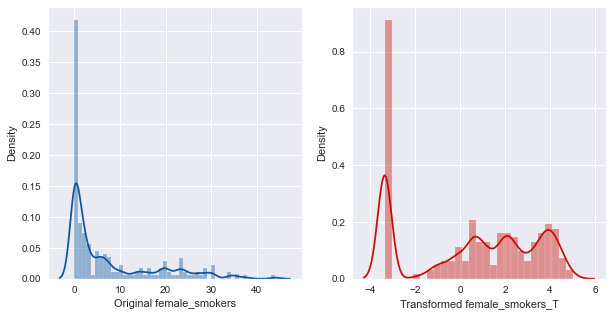


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'male_smokers' . Skewness = 0.25


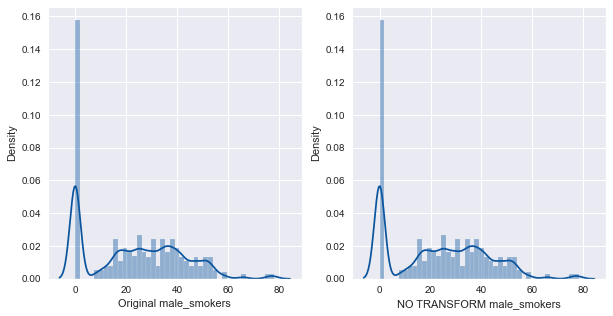


 ------------------------------------------------------

 'handwashing_facilities' had 'positive' skewness of 1.06

 Transformation yielded skewness of 0.15


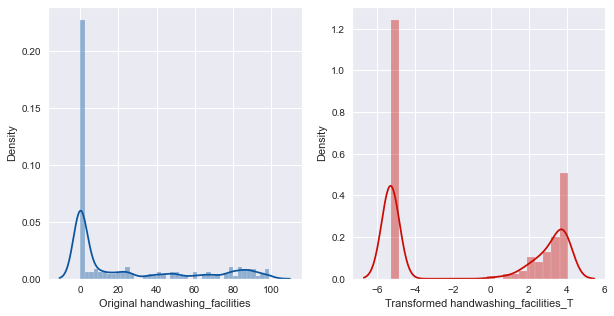


 ------------------------------------------------------

 'hospital_beds_per_thousand' had 'positive' skewness of 1.70

 Transformation yielded skewness of -0.28


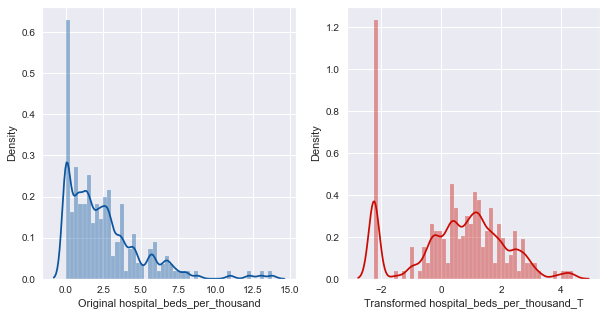


 ------------------------------------------------------

 'life_expectancy' had 'negative' skewness of -3.12

 Transformation yielded skewness of -2.14


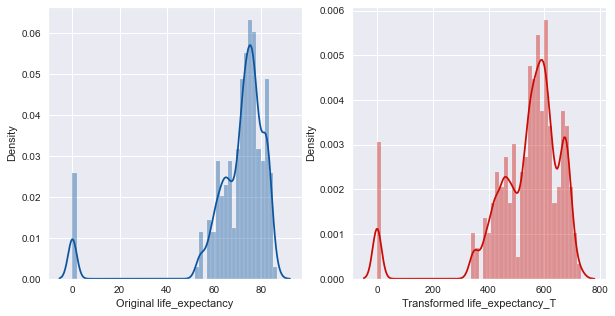


 ------------------------------------------------------

 'human_development_index' had 'negative' skewness of -1.47

 Transformation yielded skewness of -0.85


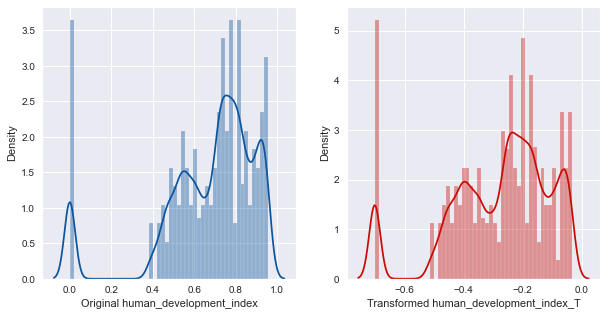


 ------------------------------------------------------

 'excess_mortality_cumulative_absolute' had 'positive' skewness of 22.14

 Transformation yielded skewness of 0.19


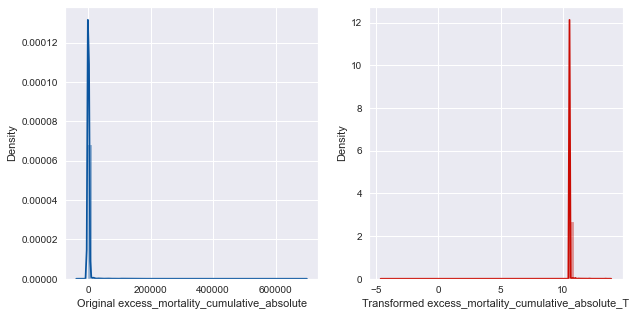


 ------------------------------------------------------

 'excess_mortality_cumulative' had 'positive' skewness of 15.24

 Transformation yielded skewness of -0.48


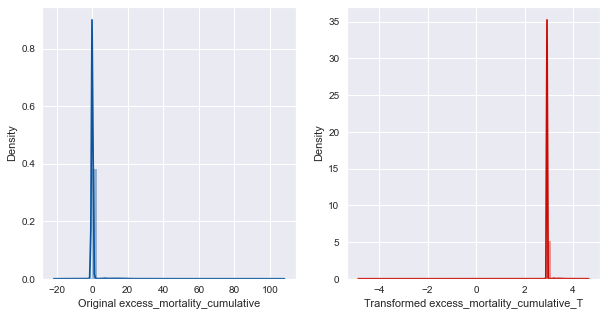


 ------------------------------------------------------

 'excess_mortality' had 'positive' skewness of 18.96

 Transformation yielded skewness of 1.23


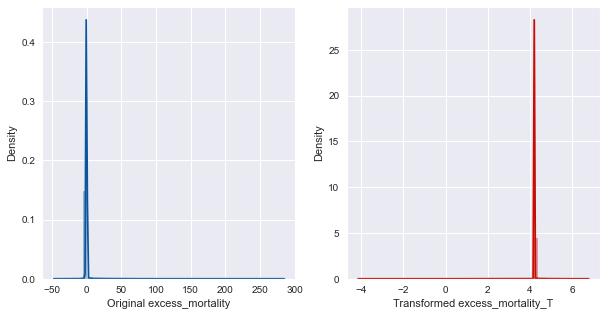


 ------------------------------------------------------

 'excess_mortality_cumulative_per_million' had 'positive' skewness of 9.42

 Transformation yielded skewness of 1.55


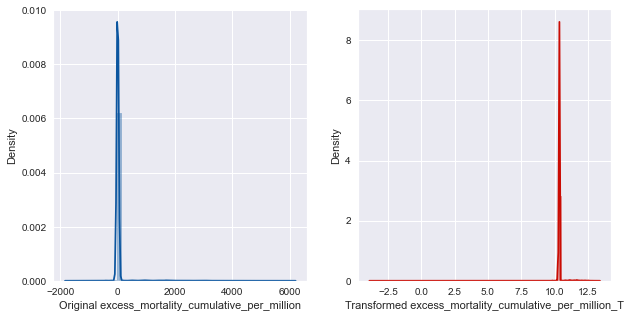


 ------------------------------------------------------

 'continent_Africa' had 'positive' skewness of 1.01

 Transformation yielded skewness of 1.01


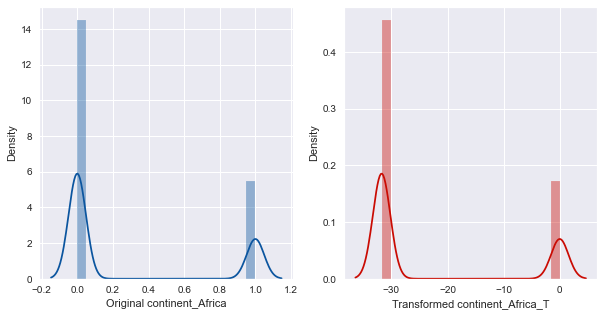


 ------------------------------------------------------

 'continent_Asia' had 'positive' skewness of 1.22

 Transformation yielded skewness of 1.22


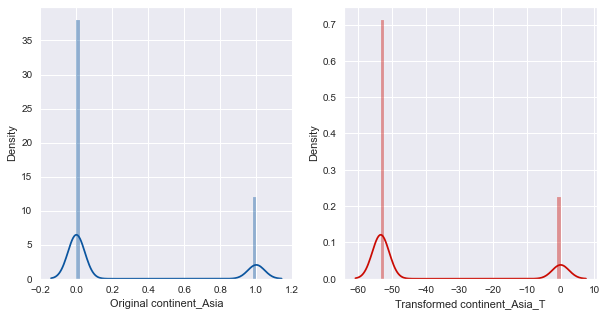


 ------------------------------------------------------

 'continent_Europe' had 'positive' skewness of 1.22

 Transformation yielded skewness of 1.22


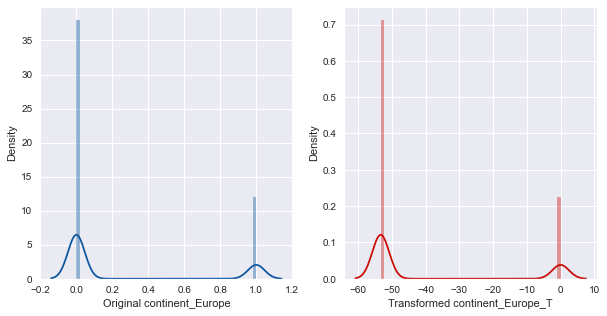


 ------------------------------------------------------

 'continent_North America' had 'positive' skewness of 2.34

 Transformation yielded skewness of 2.34


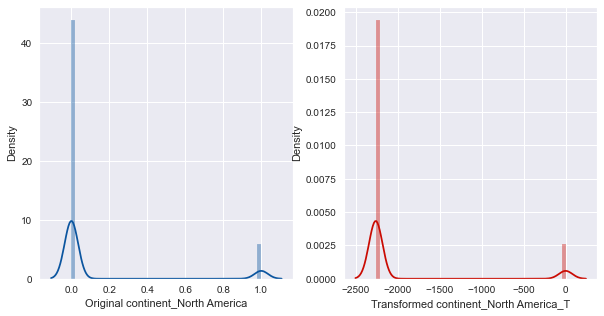


 ------------------------------------------------------

 'continent_Oceania' had 'positive' skewness of 4.03

 Transformation yielded skewness of 4.03


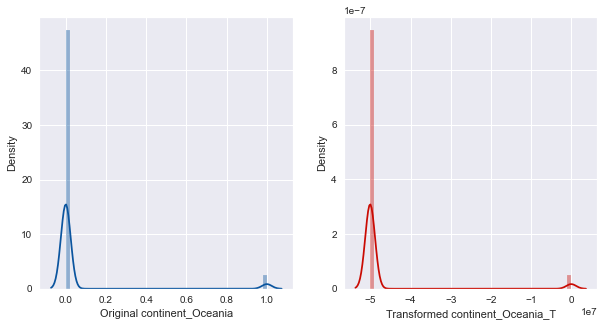


 ------------------------------------------------------

 'continent_South America' had 'positive' skewness of 3.53

 Transformation yielded skewness of 3.53


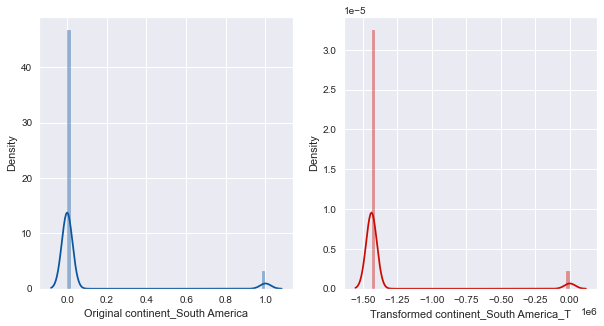


 ------------------------------------------------------

 'continent_World' had 'positive' skewness of 9.86

 Transformation yielded skewness of 9.86


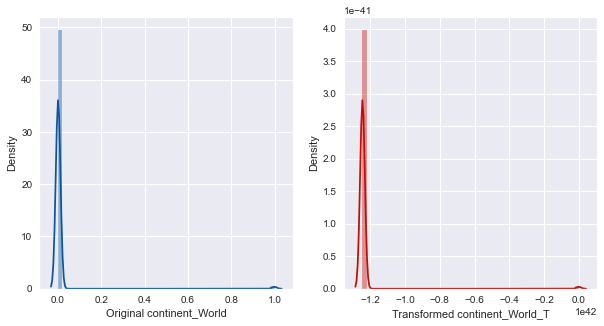


 ------------------------------------------------------

 'tests_units_people tested' had 'positive' skewness of 2.52

 Transformation yielded skewness of 2.52


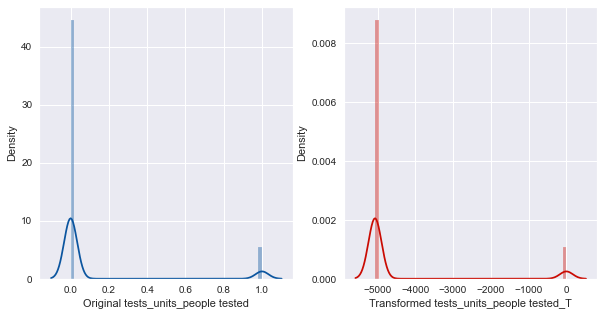


 ------------------------------------------------------

 'tests_units_samples tested' had 'positive' skewness of 2.81

 Transformation yielded skewness of 2.81


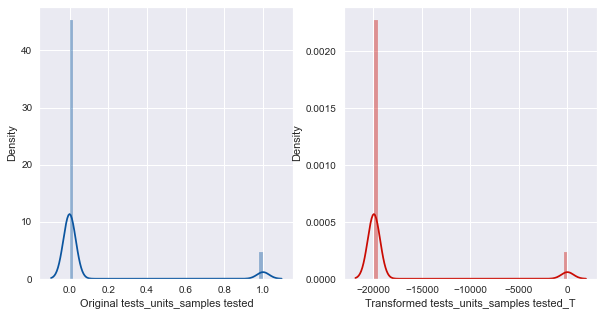


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_tests performed' . Skewness = 0.58


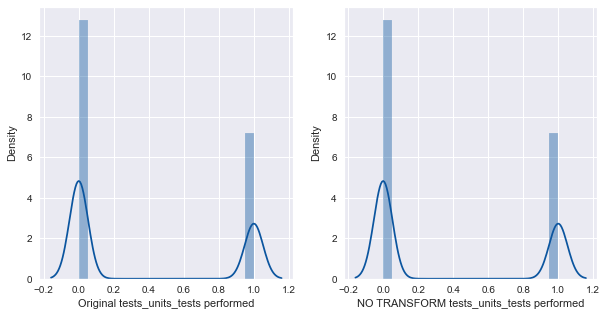


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_units unclear' . Skewness = 0.25


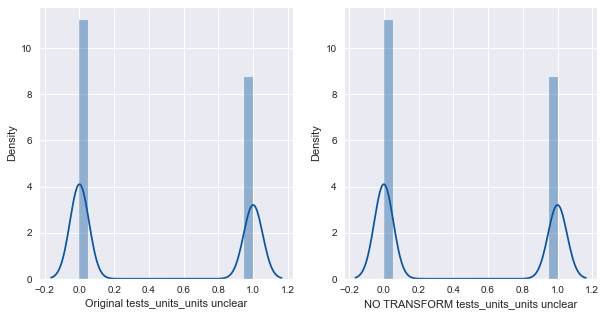

Skew AFTER Transform:
total_cases                                  10.982123
new_cases                                    10.279626
new_cases_smoothed                           10.077248
total_deaths                                 10.910948
new_deaths                                   10.301086
new_deaths_smoothed                          9.867136 
total_cases_per_million                      1.534302 
new_cases_per_million                        5.423362 
new_cases_smoothed_per_million               3.627918 
total_deaths_per_million                     2.123739 
new_deaths_per_million                       9.078775 
new_deaths_smoothed_per_million              4.313778 
reproduction_rate                           -0.708064 
icu_patients                                 16.002244
icu_patients_per_million                     5.131077 
hosp_patients                                13.971399
hosp_patients_per_million                    5.748868 
weekly_icu_admissions                      

In [793]:
#After Vaccine Correction for Skew Using BoxCox transform for any skew value over 0.8
print("Skew AFTER Transform:")
print(after_vax.skew())

after_vax_boxCox = after_vax
skew_autotransform(after_vax_boxCox, exclude = ['date'], plot = True, threshold = 0.8, exp = False)
print("Skew AFTER Transform:")
print(after_vax_boxCox.skew())

In [18]:
#Correlation of Features for the Before Vaccine Rollout Dataset
before_vax.corr()

total_cases  new_cases  \
total_cases                              1.000000     0.943091    
new_cases                                0.943091     1.000000    
new_cases_smoothed                       0.953278     0.991346    
total_deaths                             0.961717     0.923883    
new_deaths                               0.795209     0.869030    
new_deaths_smoothed                      0.812498     0.867545    
total_cases_per_million                  0.133737     0.121325    
new_cases_per_million                    0.065219     0.106742    
new_cases_smoothed_per_million           0.082121     0.119537    
total_deaths_per_million                 0.145703     0.128818    
new_deaths_per_million                   0.053691     0.077744    
new_deaths_smoothed_per_million          0.072843     0.096171    
reproduction_rate                       -0.038050    -0.036151    
icu_patients                             0.157206     0.159907    
icu_patients_per_million                 0.032238     0.045525    
hosp_patients                            0.136592     0.149691    
hosp_patients_per_million                0.015651     0.034328    
weekly_icu_admissions                    0.003021     0.005428    
weekly_icu_admissions_per_million       -0.001057    -0.000869    
weekly_hosp_admissions                   0.060257     0.052987    
weekly_hosp_admissions_per_million       0.009965     0.010261    
new_tests                                0.206464     0.205439    
total_tests                              0.214827     0.187127    
total_tests_per_thousand                 0.005687     0.001385    
new_tests_per_thousand                   0.000720     0.004107    
new_tests_smoothed                       0.211200     0.207063    
new_tests_smoothed_per_thousand         -0.001379     0.001070    
positive_rate                           -0.023046    -0.012311    
tests_per_case                          -0.017407    -0.019564    
stringency_index                        -0.160464    -0.169771    
population                               0.611340     0.644439    
population_density                      -0.023712    -0.025743    
median_age                              -0.083418    -0.091580    
aged_65_older                           -0.036475    -0.036324    
aged_70_older                           -0.036932    -0.036437    
gdp_per_capita                          -0.029070    -0.032351    
extreme_poverty                         -0.027882    -0.031402    
cardiovasc_death_rate                   -0.101478    -0.111945    
diabetes_prevalence                     -0.058139    -0.068904    
female_smokers                          -0.021866    -0.020442    
male_smokers                            -0.030270    -0.033567    
handwashing_facilities                   0.008095     0.005569    
hospital_beds_per_thousand              -0.047223    -0.048527    
life_expectancy                         -0.178876    -0.199021    
human_development_index                 -0.107100    -0.119546    
excess_mortality_cumulative_absolute     0.056986     0.043904    
excess_mortality_cumulative              0.010161     0.005975    
excess_mortality                         0.002380     0.004407    
excess_mortality_cumulative_per_million  0.017314     0.011297    
continent_Africa                        -0.078067    -0.085586    
continent_Asia                          -0.025529    -0.031113    
continent_Europe                        -0.026634    -0.008334    
continent_North America                  0.021713     0.017800    
continent_Oceania                       -0.024144    -0.026223    
continent_South America                  0.039998     0.027651    
continent_World                          0.415654     0.438996    
tests_units_people tested               -0.030541    -0.030814    
tests_units_samples tested              -0.018386    -0.019850    
tests_units_tests performed             -0.043885    -0.047411    
tests_units_units unc

In [19]:
before_vax_highCorr = before_vax.drop(['date'], axis=1)

def get_redundant_pairs(before_vax_highCorr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = before_vax_highCorr.columns
    for i in range(0, before_vax_highCorr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(before_vax_highCorr, n=10):
    au_corr = before_vax_highCorr.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(before_vax_highCorr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations:")
print()
list_corr = get_top_abs_correlations(before_vax_highCorr)
print(get_top_abs_correlations(before_vax_highCorr, 25))

Top Absolute Correlations:

new_cases                    new_cases_smoothed                         0.991346
new_deaths                   new_deaths_smoothed                        0.978005
new_tests                    new_tests_smoothed                         0.974299
aged_65_older                aged_70_older                              0.965812
total_cases                  total_deaths                               0.961717
                             new_cases_smoothed                         0.953278
                             new_cases                                  0.943091
total_tests                  new_tests_smoothed                         0.932103
new_cases_smoothed           total_deaths                               0.931491
new_cases                    total_deaths                               0.923883
new_tests                    total_tests                                0.920121
icu_patients                 hosp_patients                              0.911314


Skew BEFORE Transform:
total_cases                                15.833084
new_cases                                  14.054065
new_cases_smoothed                         13.997353
total_deaths                               13.047434
new_deaths                                 10.722486
new_deaths_smoothed                        10.394499
total_cases_per_million                    3.692359 
new_cases_per_million                      15.762145
new_cases_smoothed_per_million             5.918354 
total_deaths_per_million                   4.994199 
new_deaths_per_million                     19.346285
new_deaths_smoothed_per_million            6.815021 
reproduction_rate                          0.097742 
icu_patients                               17.633006
icu_patients_per_million                   7.370604 
hosp_patients                              13.854291
hosp_patients_per_million                  7.610030 
weekly_icu_admissions                      47.757394
weekly_icu_admissions_p

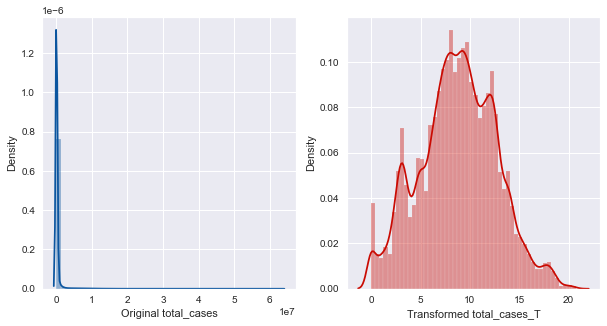


 ------------------------------------------------------

 'new_cases' had 'positive' skewness of 14.05

 Transformation yielded skewness of 0.47


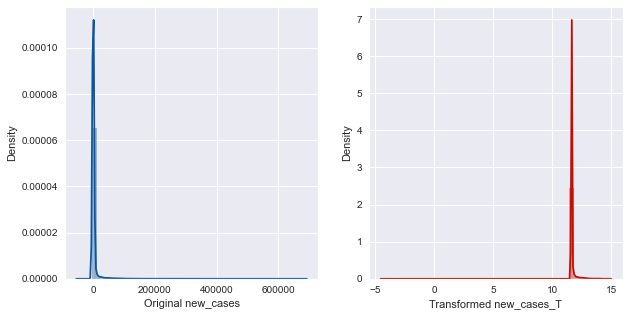


 ------------------------------------------------------

 'new_cases_smoothed' had 'positive' skewness of 14.00

 Transformation yielded skewness of -6.08


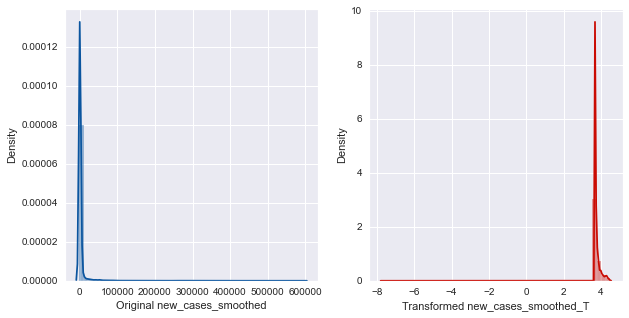


 ------------------------------------------------------

 'total_deaths' had 'positive' skewness of 13.05

 Transformation yielded skewness of -0.02


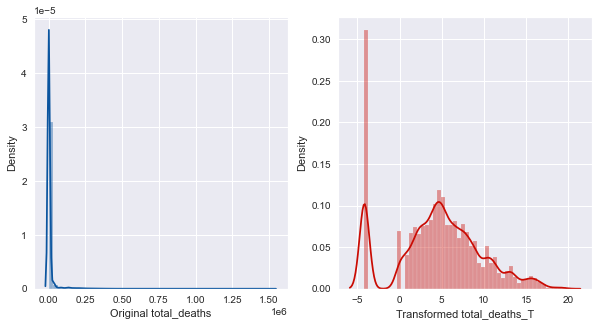


 ------------------------------------------------------

 'new_deaths' had 'positive' skewness of 10.72

 Transformation yielded skewness of 0.91


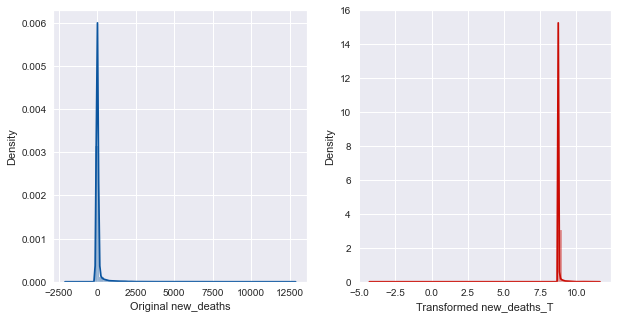


 ------------------------------------------------------

 'new_deaths_smoothed' had 'positive' skewness of 10.39

 Transformation yielded skewness of -5.12


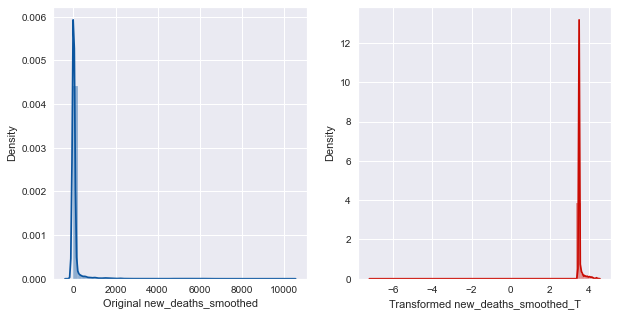


 ------------------------------------------------------

 'total_cases_per_million' had 'positive' skewness of 3.69

 Transformation yielded skewness of -0.08


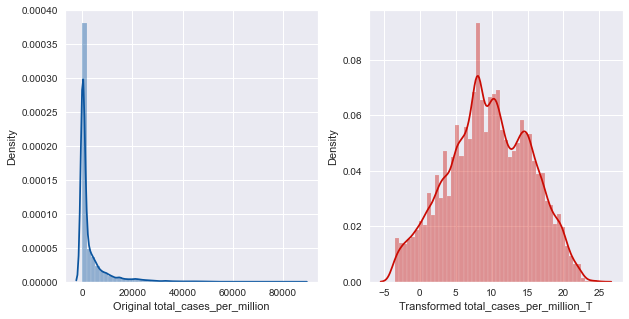


 ------------------------------------------------------

 'new_cases_per_million' had 'positive' skewness of 15.76

 Transformation yielded skewness of 3.78


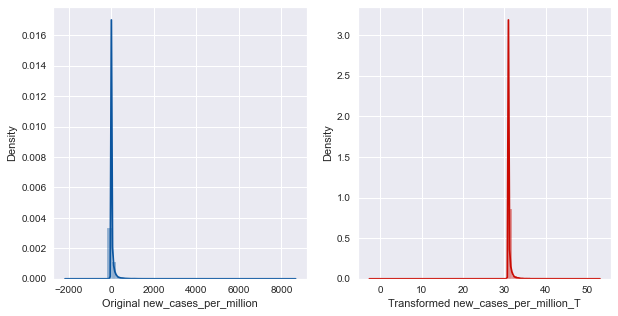


 ------------------------------------------------------

 'new_cases_smoothed_per_million' had 'positive' skewness of 5.92

 Transformation yielded skewness of -0.34


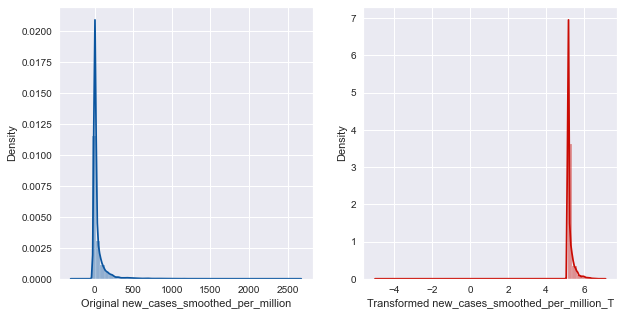


 ------------------------------------------------------

 'total_deaths_per_million' had 'positive' skewness of 4.99

 Transformation yielded skewness of -0.11


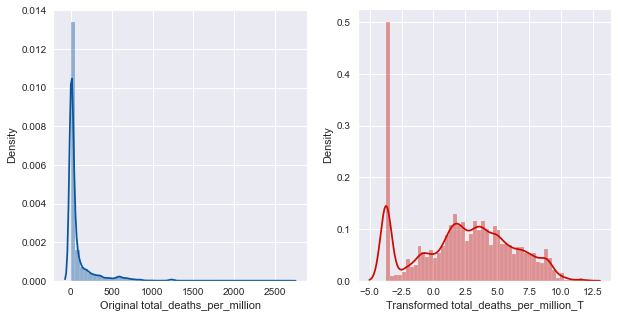


 ------------------------------------------------------

 'new_deaths_per_million' had 'positive' skewness of 19.35

 Transformation yielded skewness of 5.47


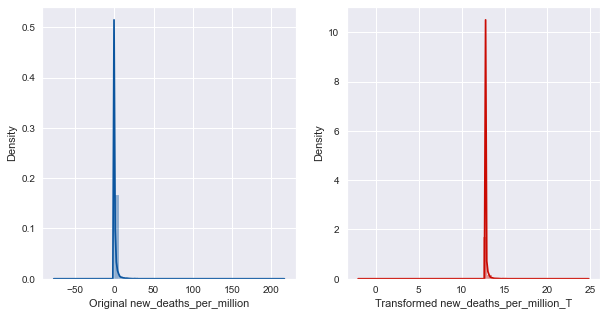


 ------------------------------------------------------

 'new_deaths_smoothed_per_million' had 'positive' skewness of 6.82

 Transformation yielded skewness of 1.12


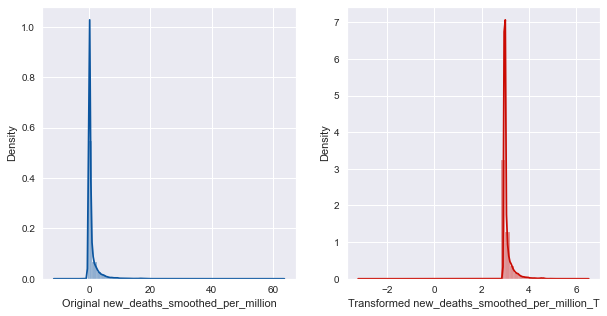


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'reproduction_rate' . Skewness = 0.10


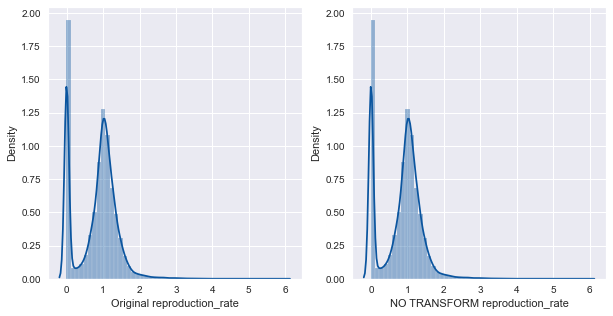


 ------------------------------------------------------

 'icu_patients' had 'positive' skewness of 17.63

 Transformation yielded skewness of 2.50


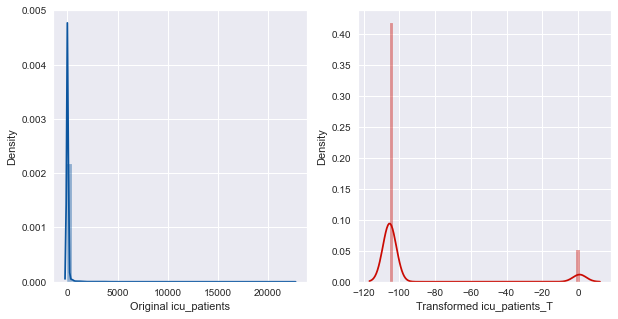


 ------------------------------------------------------

 'icu_patients_per_million' had 'positive' skewness of 7.37

 Transformation yielded skewness of 2.50


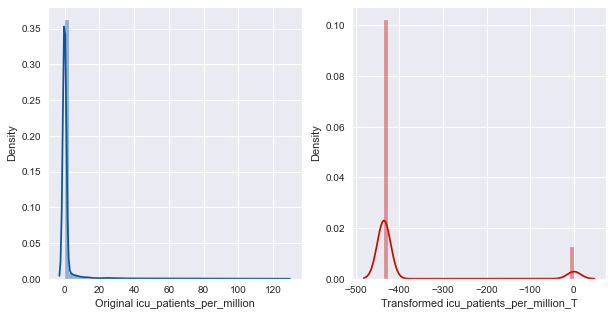


 ------------------------------------------------------

 'hosp_patients' had 'positive' skewness of 13.85

 Transformation yielded skewness of 2.15


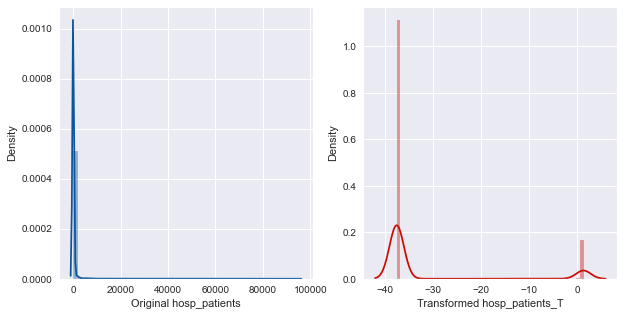


 ------------------------------------------------------

 'hosp_patients_per_million' had 'positive' skewness of 7.61

 Transformation yielded skewness of 2.15


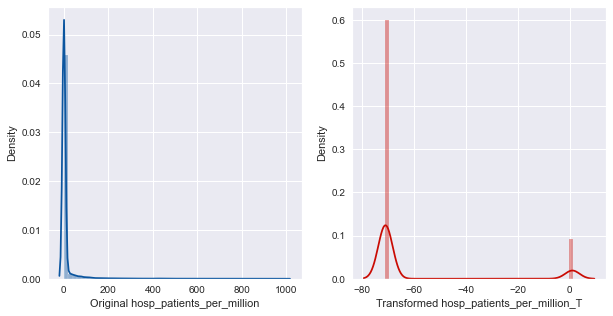


 ------------------------------------------------------

 'weekly_icu_admissions' had 'positive' skewness of 47.76

 Transformation yielded skewness of 10.41


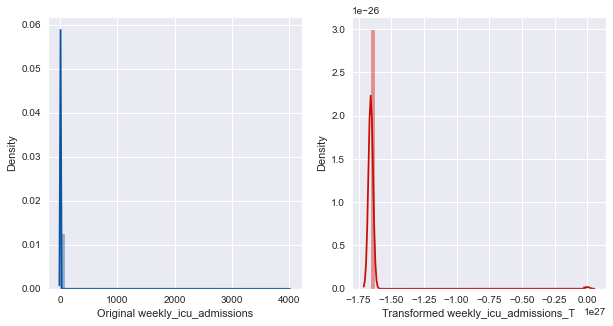


 ------------------------------------------------------

 'weekly_icu_admissions_per_million' had 'positive' skewness of 46.09

 Transformation yielded skewness of 10.41


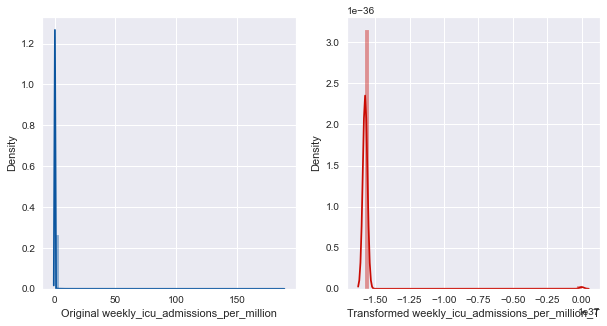


 ------------------------------------------------------

 'weekly_hosp_admissions' had 'positive' skewness of 51.16

 Transformation yielded skewness of 7.47


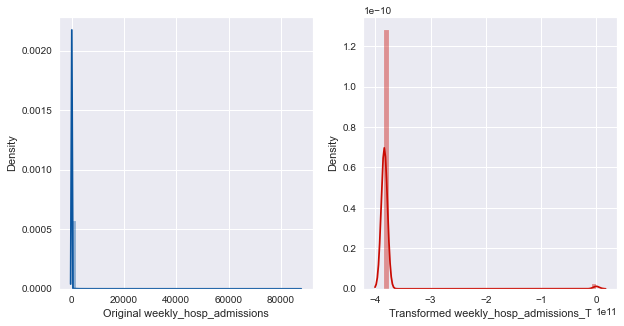


 ------------------------------------------------------

 'weekly_hosp_admissions_per_million' had 'positive' skewness of 37.31

 Transformation yielded skewness of 7.47


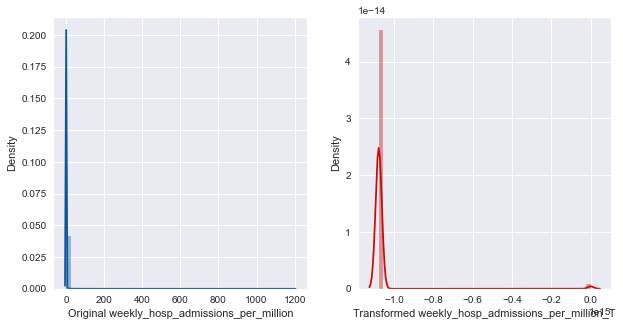


 ------------------------------------------------------

 'new_tests' had 'positive' skewness of 12.38

 Transformation yielded skewness of 0.24


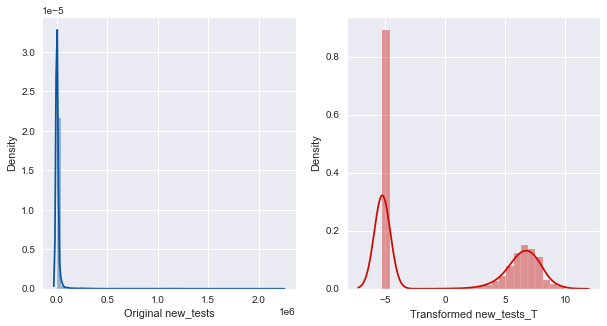


 ------------------------------------------------------

 'total_tests' had 'positive' skewness of 14.45

 Transformation yielded skewness of 0.23


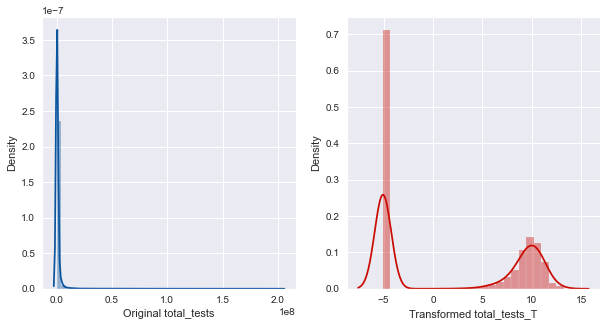


 ------------------------------------------------------

 'total_tests_per_thousand' had 'positive' skewness of 6.93

 Transformation yielded skewness of 0.35


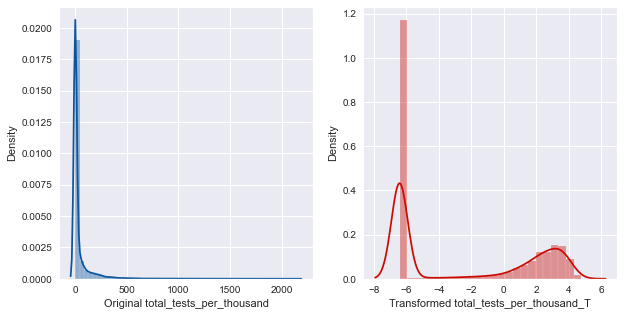


 ------------------------------------------------------

 'new_tests_per_thousand' had 'positive' skewness of 6.74

 Transformation yielded skewness of 0.48


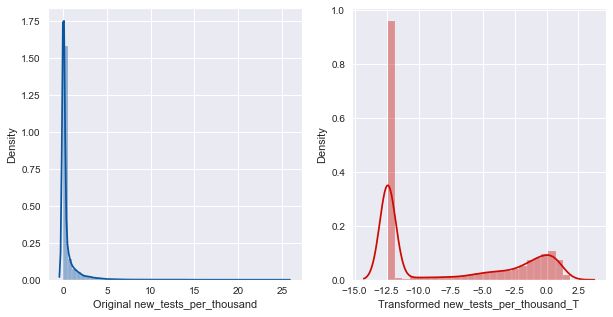


 ------------------------------------------------------

 'new_tests_smoothed' had 'positive' skewness of 11.76

 Transformation yielded skewness of 0.04


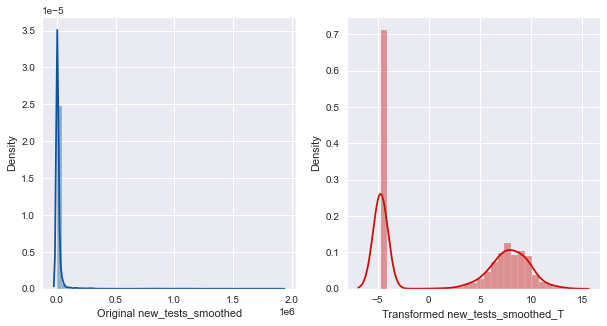


 ------------------------------------------------------

 'new_tests_smoothed_per_thousand' had 'positive' skewness of 5.68

 Transformation yielded skewness of 0.33


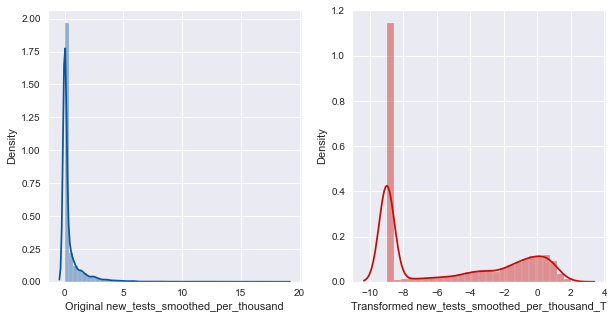


 ------------------------------------------------------

 'positive_rate' had 'positive' skewness of 2.91

 Transformation yielded skewness of 0.57


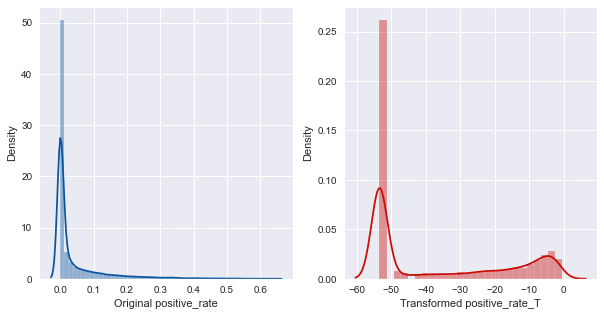


 ------------------------------------------------------

 'tests_per_case' had 'positive' skewness of 32.57

 Transformation yielded skewness of 0.21


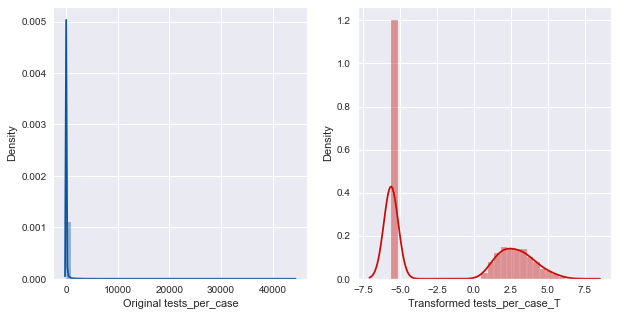


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'stringency_index' . Skewness = -0.56


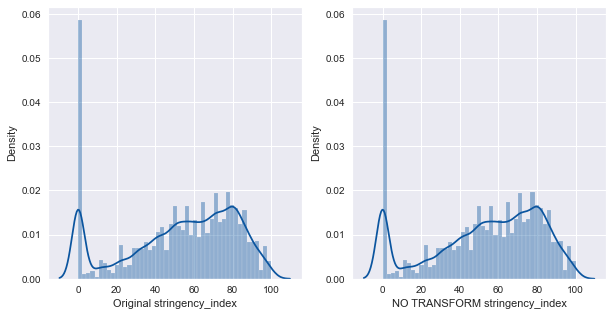


 ------------------------------------------------------

 'population' had 'positive' skewness of 8.86

 Transformation yielded skewness of 0.20


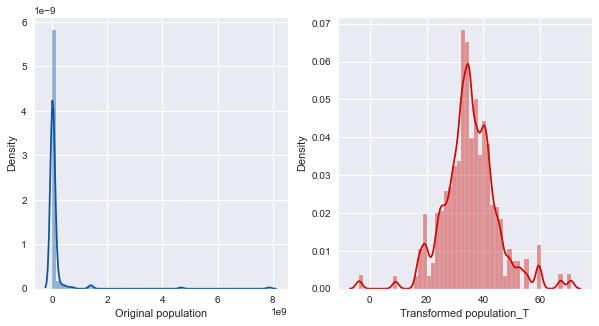


 ------------------------------------------------------

 'population_density' had 'positive' skewness of 9.72

 Transformation yielded skewness of 0.24


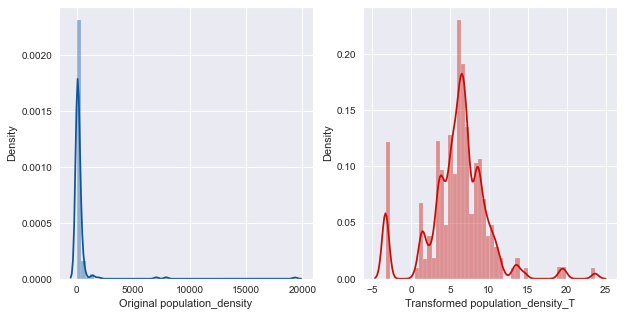


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'median_age' . Skewness = -0.66


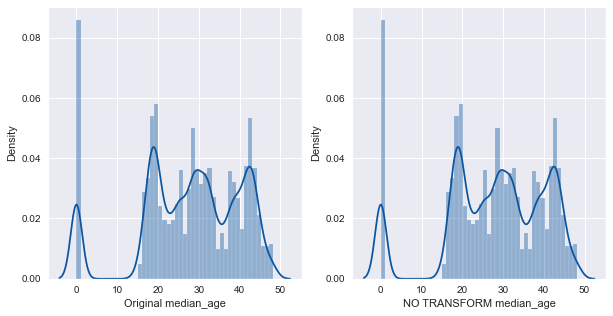


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'aged_65_older' . Skewness = 0.76


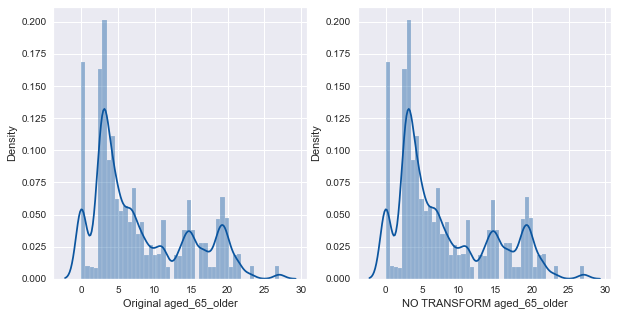


 ------------------------------------------------------

 'aged_70_older' had 'positive' skewness of 0.91

 Transformation yielded skewness of -0.21


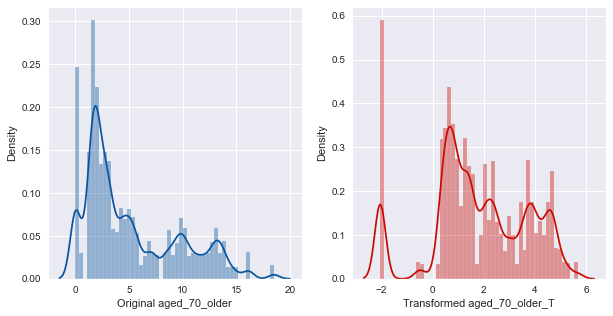


 ------------------------------------------------------

 'gdp_per_capita' had 'positive' skewness of 1.81

 Transformation yielded skewness of -0.46


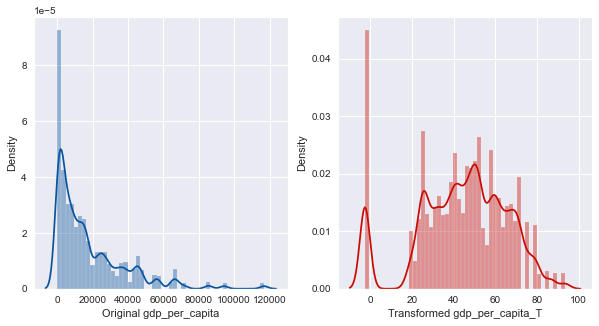


 ------------------------------------------------------

 'extreme_poverty' had 'positive' skewness of 2.41

 Transformation yielded skewness of 0.07


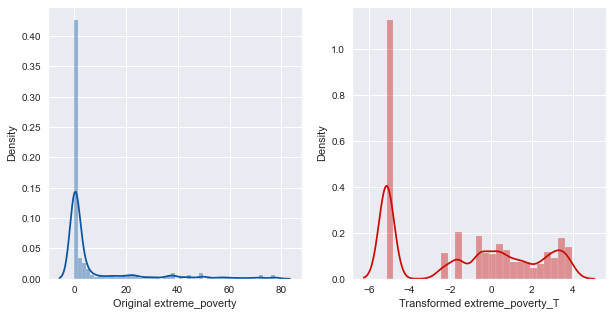


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'cardiovasc_death_rate' . Skewness = 0.46


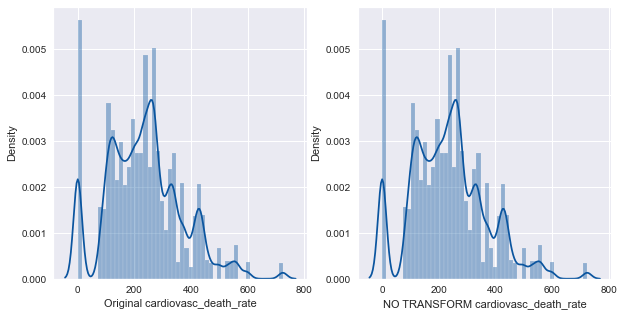


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'diabetes_prevalence' . Skewness = 0.69


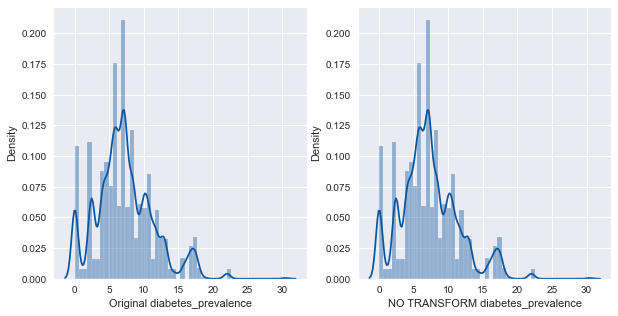


 ------------------------------------------------------

 'female_smokers' had 'positive' skewness of 1.34

 Transformation yielded skewness of -0.23


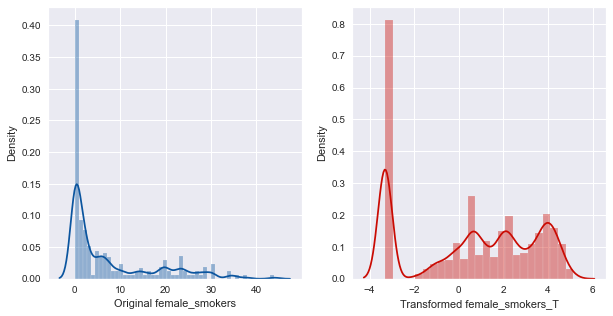


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'male_smokers' . Skewness = 0.23


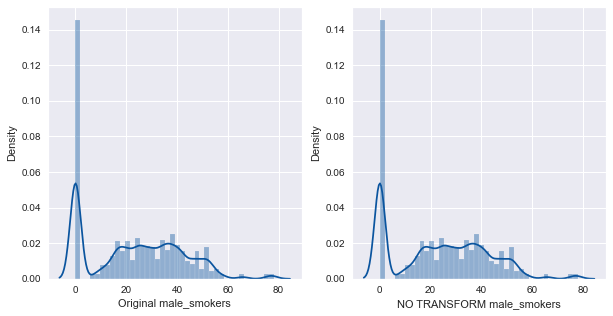


 ------------------------------------------------------

 'handwashing_facilities' had 'positive' skewness of 1.08

 Transformation yielded skewness of 0.21


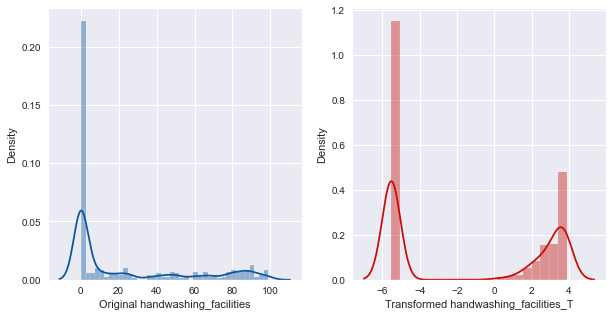


 ------------------------------------------------------

 'hospital_beds_per_thousand' had 'positive' skewness of 1.70

 Transformation yielded skewness of -0.27


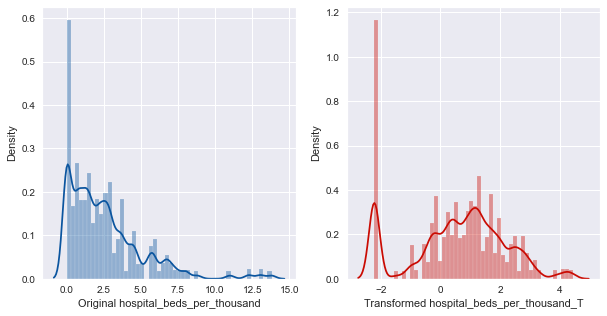


 ------------------------------------------------------

 'life_expectancy' had 'negative' skewness of -3.01

 Transformation yielded skewness of -2.23


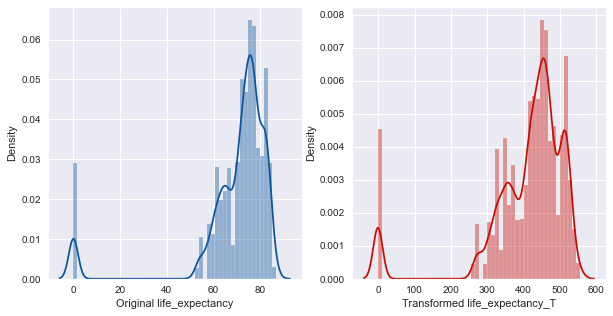


 ------------------------------------------------------

 'human_development_index' had 'negative' skewness of -1.48

 Transformation yielded skewness of -0.91


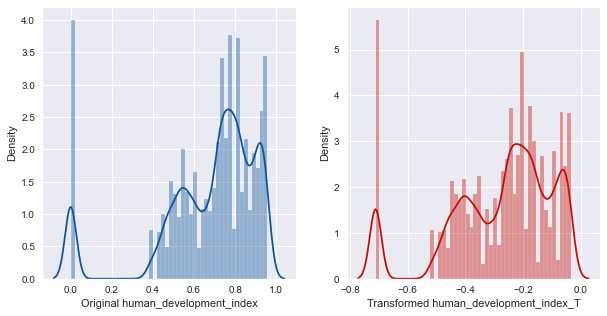


 ------------------------------------------------------

 'excess_mortality_cumulative_absolute' had 'positive' skewness of 25.47

 Transformation yielded skewness of 3.99


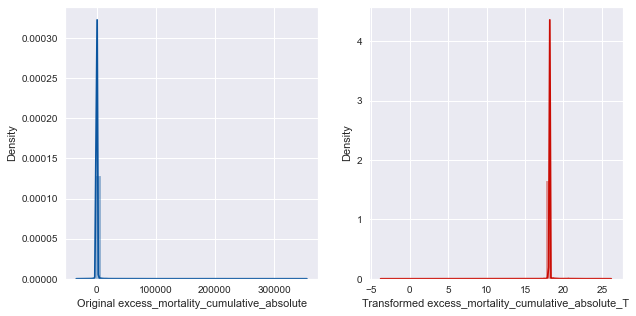


 ------------------------------------------------------

 'excess_mortality_cumulative' had 'positive' skewness of 17.19

 Transformation yielded skewness of 2.16


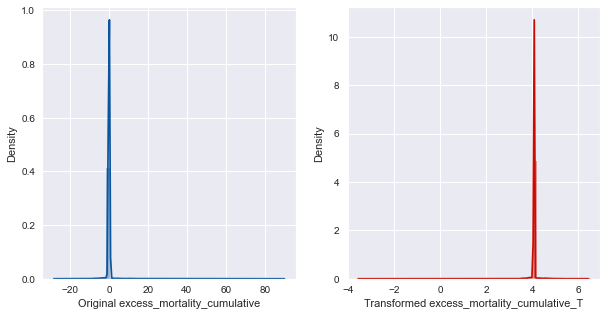


 ------------------------------------------------------

 'excess_mortality' had 'positive' skewness of 18.42

 Transformation yielded skewness of 4.63


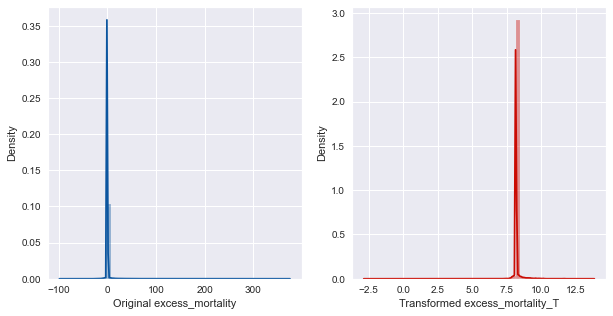


 ------------------------------------------------------

 'excess_mortality_cumulative_per_million' had 'positive' skewness of 11.87

 Transformation yielded skewness of 3.87


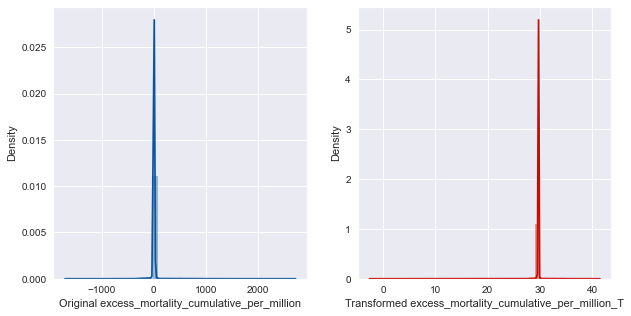


 ------------------------------------------------------

 'continent_Africa' had 'positive' skewness of 1.06

 Transformation yielded skewness of 1.06


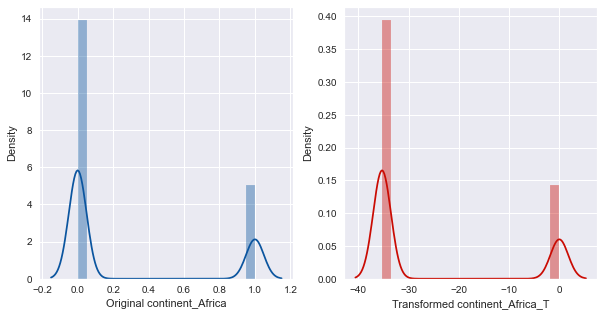


 ------------------------------------------------------

 'continent_Asia' had 'positive' skewness of 1.13

 Transformation yielded skewness of 1.13


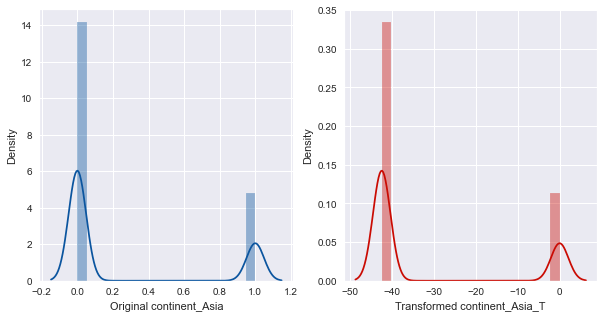


 ------------------------------------------------------

 'continent_Europe' had 'positive' skewness of 1.14

 Transformation yielded skewness of 1.14


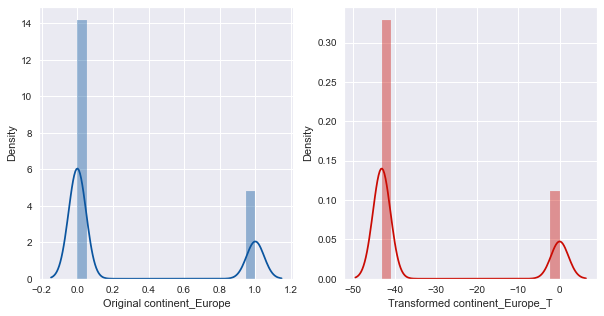


 ------------------------------------------------------

 'continent_North America' had 'positive' skewness of 2.33

 Transformation yielded skewness of 2.33


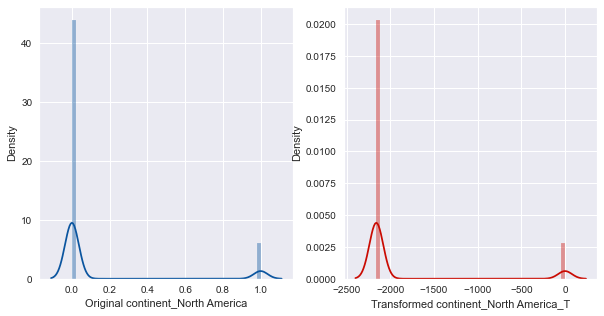


 ------------------------------------------------------

 'continent_Oceania' had 'positive' skewness of 5.65

 Transformation yielded skewness of 5.65


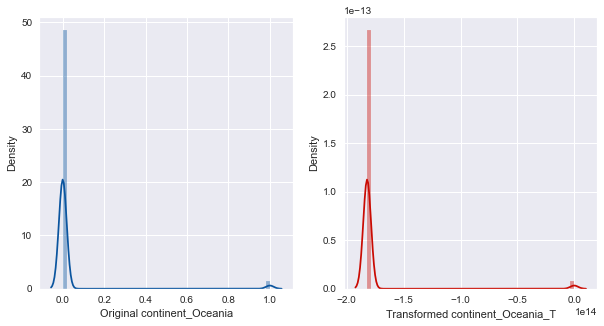


 ------------------------------------------------------

 'continent_South America' had 'positive' skewness of 3.50

 Transformation yielded skewness of 3.50


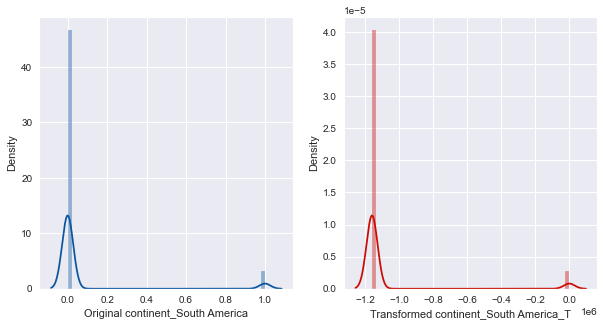


 ------------------------------------------------------

 'continent_World' had 'positive' skewness of 9.18

 Transformation yielded skewness of 9.18


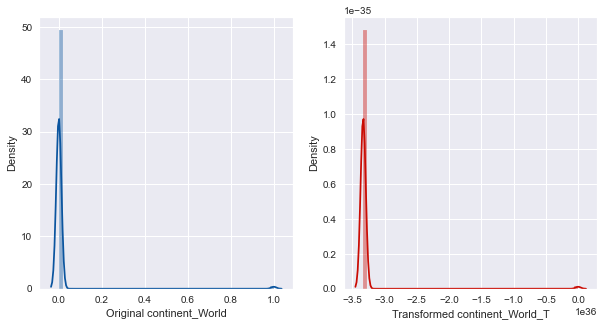


 ------------------------------------------------------

 'tests_units_people tested' had 'positive' skewness of 2.68

 Transformation yielded skewness of 2.68


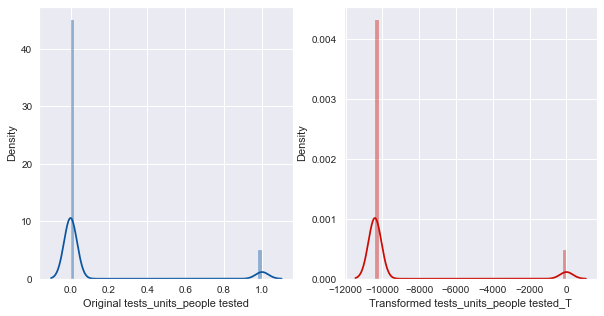


 ------------------------------------------------------

 'tests_units_samples tested' had 'positive' skewness of 2.86

 Transformation yielded skewness of 2.86


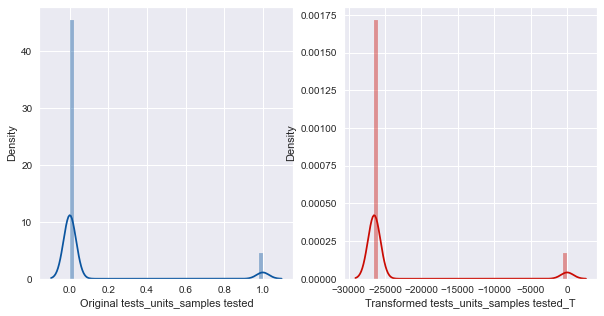


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_tests performed' . Skewness = 0.68


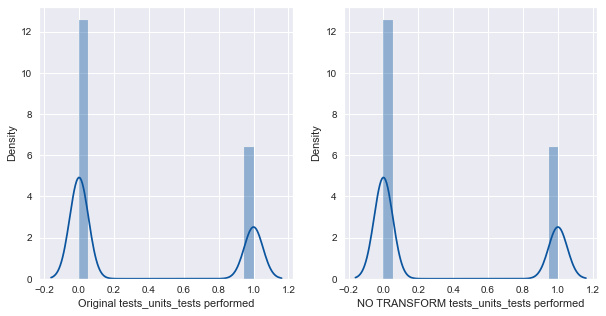


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_units unclear' . Skewness = 0.11


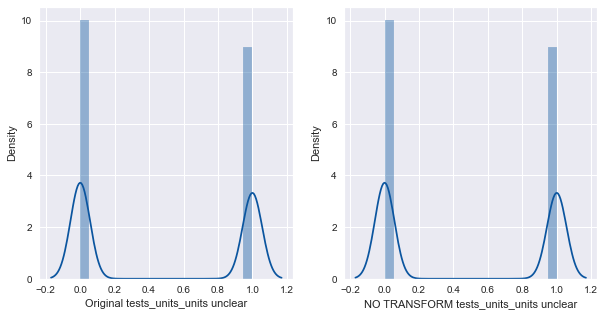

Skew AFTER Transform:
total_cases                                  15.833084
new_cases                                    14.054065
new_cases_smoothed                           13.997353
total_deaths                                 13.047434
new_deaths                                   10.722486
new_deaths_smoothed                          10.394499
total_cases_per_million                      3.692359 
new_cases_per_million                        15.762145
new_cases_smoothed_per_million               5.918354 
total_deaths_per_million                     4.994199 
new_deaths_per_million                       19.346285
new_deaths_smoothed_per_million              6.815021 
reproduction_rate                            0.097742 
icu_patients                                 17.633006
icu_patients_per_million                     7.370604 
hosp_patients                                13.854291
hosp_patients_per_million                    7.610030 
weekly_icu_admissions                      

In [503]:
#Before Vaccine Correction for Skew Using BoxCox transform for any skew value over 0.8
print("Skew BEFORE Transform:")
print(before_vax.skew())

before_vax_boxT = before_vax
skew_autotransform(before_vax_boxT, exclude = ['location','tests_units','date'], plot = True, threshold = 0.8, exp = False)
before_vax = pd.read_csv('before_vaccination_w_continents_dummy.csv')

print("Skew AFTER Transform:")
print(before_vax_boxT.skew())

In [21]:
before_vax_boxT.tail().T
before_vax_boxT.to_csv('before_vax_feature_transforms.csv')

Skew BEFORE Transform:
total_cases                                10.982123
new_cases                                  10.279626
new_cases_smoothed                         10.077248
total_deaths                               10.910948
new_deaths                                 10.301086
new_deaths_smoothed                        9.867136 
total_cases_per_million                    1.534302 
new_cases_per_million                      5.423362 
new_cases_smoothed_per_million             3.627918 
total_deaths_per_million                   2.123739 
new_deaths_per_million                     9.078775 
new_deaths_smoothed_per_million            4.313778 
reproduction_rate                         -0.708064 
icu_patients                               16.002244
icu_patients_per_million                   5.131077 
hosp_patients                              13.971399
hosp_patients_per_million                  5.748868 
weekly_icu_admissions                      32.931660
weekly_icu_admissions_p

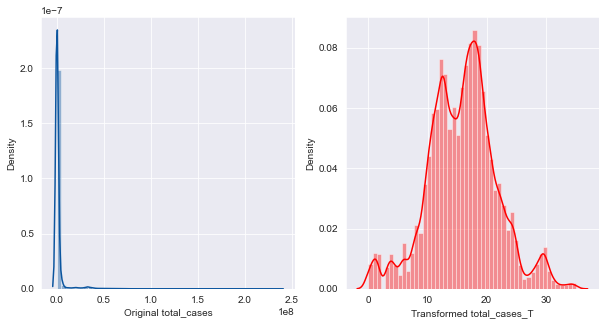


 ------------------------------------------------------

 'new_cases' had 'positive' skewness of 10.28

 Transformation yielded skewness of -0.29


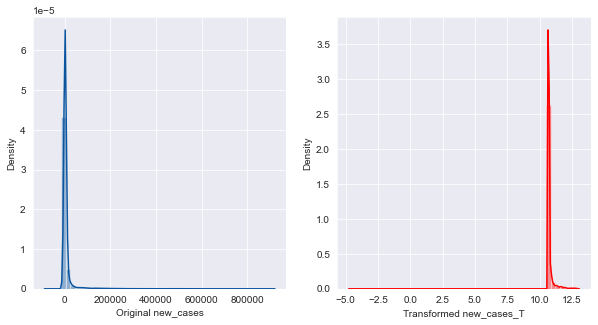


 ------------------------------------------------------

 'new_cases_smoothed' had 'positive' skewness of 10.08

 Transformation yielded skewness of -5.03


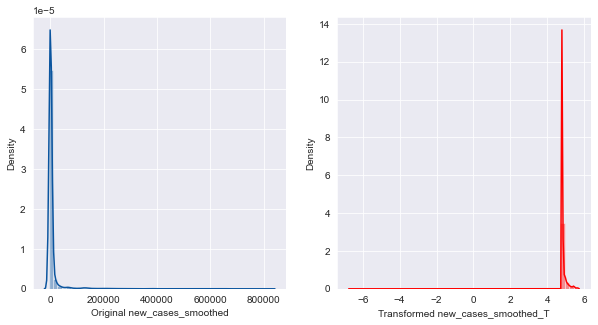


 ------------------------------------------------------

 'total_deaths' had 'positive' skewness of 10.91

 Transformation yielded skewness of 0.04


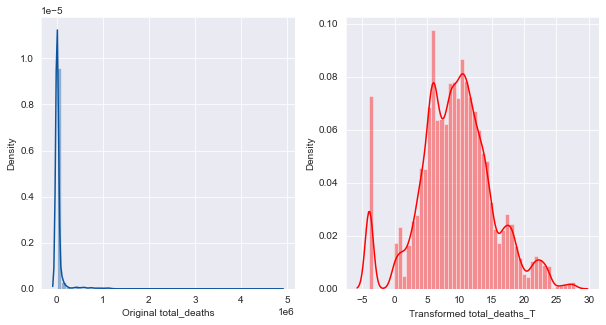


 ------------------------------------------------------

 'new_deaths' had 'positive' skewness of 10.30

 Transformation yielded skewness of -3.99


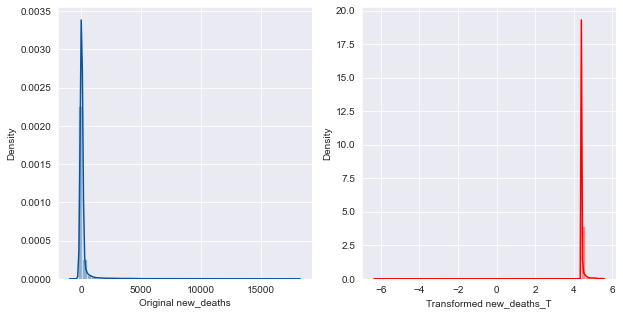


 ------------------------------------------------------

 'new_deaths_smoothed' had 'positive' skewness of 9.87

 Transformation yielded skewness of 0.17


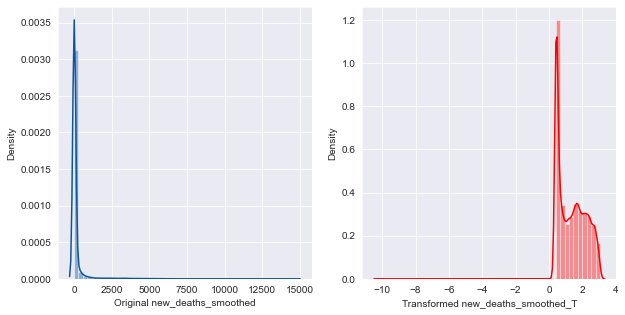


 ------------------------------------------------------

 'total_cases_per_million' had 'positive' skewness of 1.53

 Transformation yielded skewness of -0.18


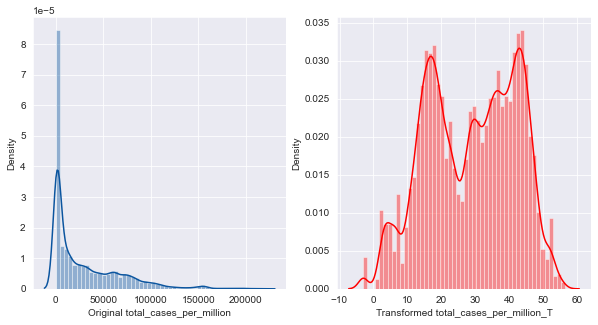


 ------------------------------------------------------

 'new_cases_per_million' had 'positive' skewness of 5.42

 Transformation yielded skewness of 1.92


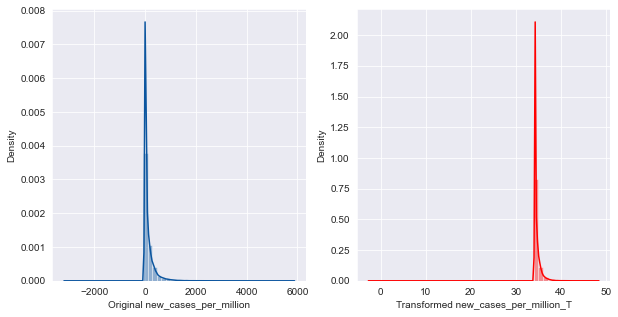


 ------------------------------------------------------

 'new_cases_smoothed_per_million' had 'positive' skewness of 3.63

 Transformation yielded skewness of -1.06


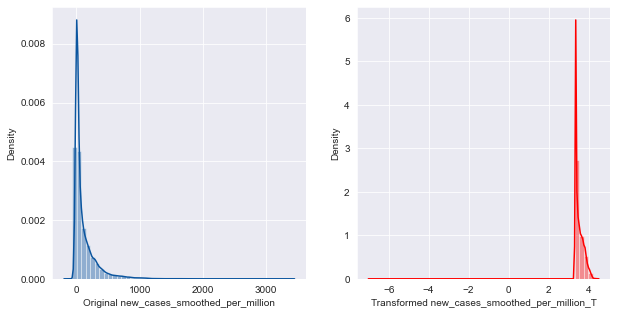


 ------------------------------------------------------

 'total_deaths_per_million' had 'positive' skewness of 2.12

 Transformation yielded skewness of -0.19


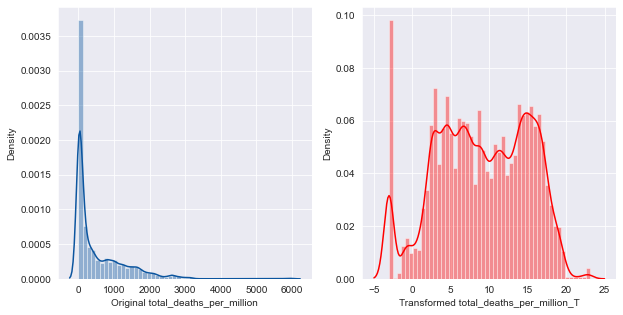


 ------------------------------------------------------

 'new_deaths_per_million' had 'positive' skewness of 9.08

 Transformation yielded skewness of -0.35


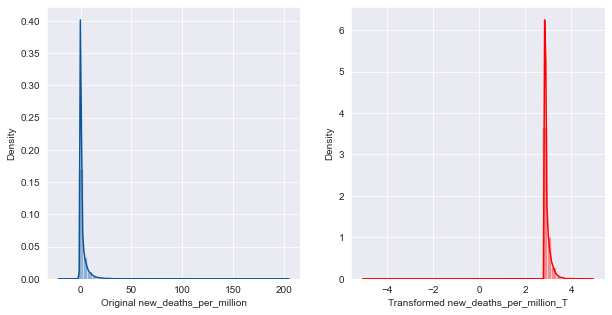


 ------------------------------------------------------

 'new_deaths_smoothed_per_million' had 'positive' skewness of 4.31

 Transformation yielded skewness of -1.77


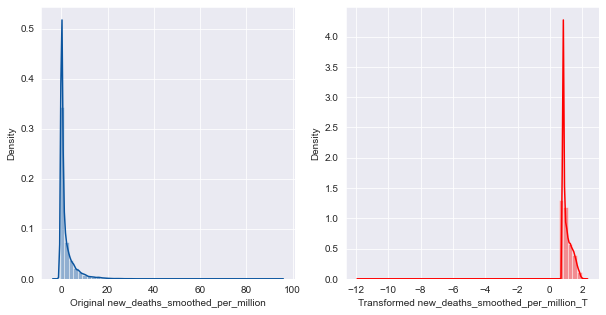


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'reproduction_rate' . Skewness = -0.71


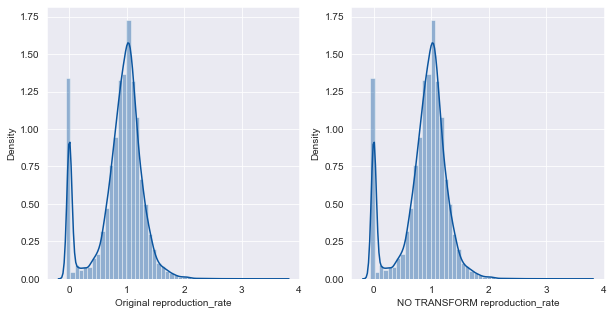


 ------------------------------------------------------

 'icu_patients' had 'positive' skewness of 16.00

 Transformation yielded skewness of 2.22


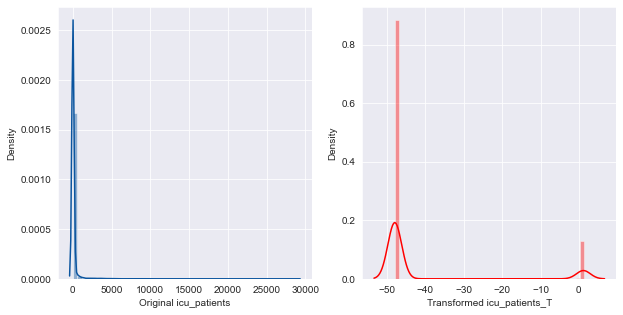


 ------------------------------------------------------

 'icu_patients_per_million' had 'positive' skewness of 5.13

 Transformation yielded skewness of 2.22


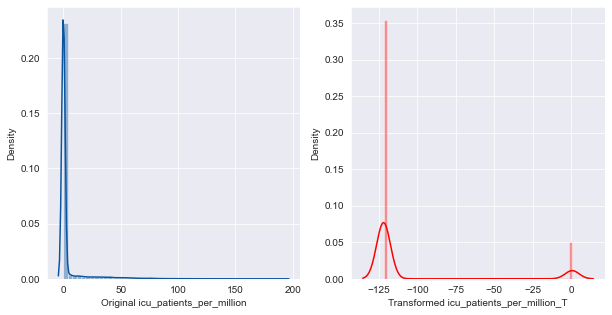


 ------------------------------------------------------

 'hosp_patients' had 'positive' skewness of 13.97

 Transformation yielded skewness of 2.00


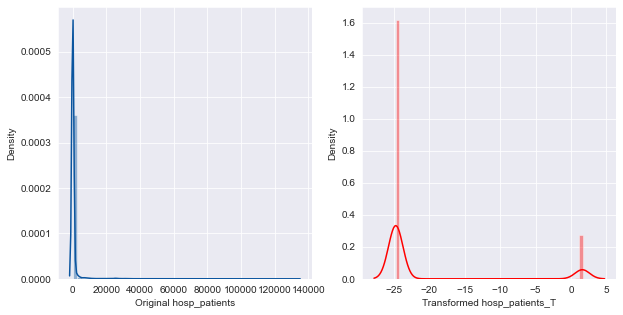


 ------------------------------------------------------

 'hosp_patients_per_million' had 'positive' skewness of 5.75

 Transformation yielded skewness of 2.00


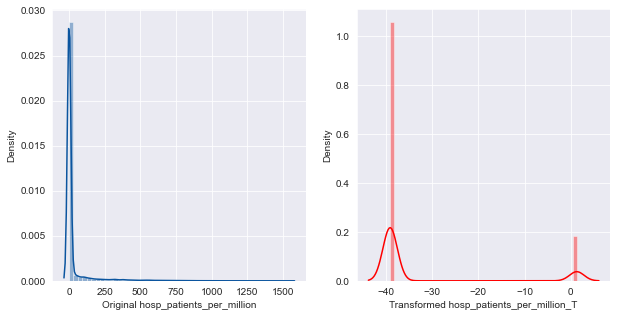


 ------------------------------------------------------

 'weekly_icu_admissions' had 'positive' skewness of 32.93

 Transformation yielded skewness of 9.32


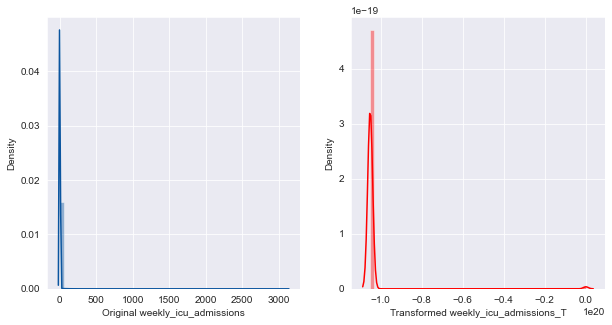


 ------------------------------------------------------

 'weekly_icu_admissions_per_million' had 'positive' skewness of 34.54

 Transformation yielded skewness of 9.32


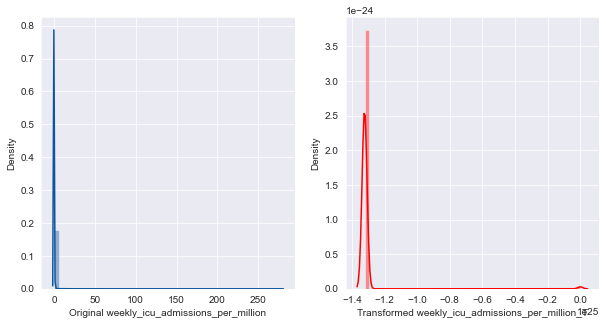


 ------------------------------------------------------

 'weekly_hosp_admissions' had 'positive' skewness of 45.54

 Transformation yielded skewness of 7.26


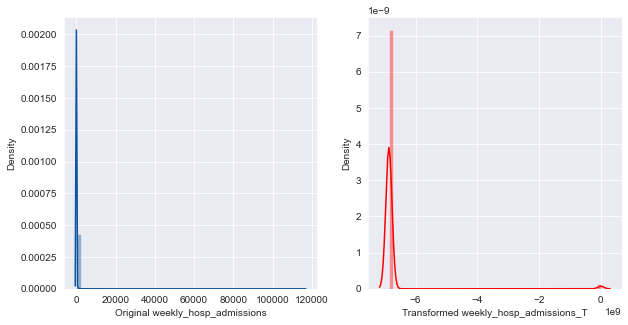


 ------------------------------------------------------

 'weekly_hosp_admissions_per_million' had 'positive' skewness of 27.36

 Transformation yielded skewness of 7.26


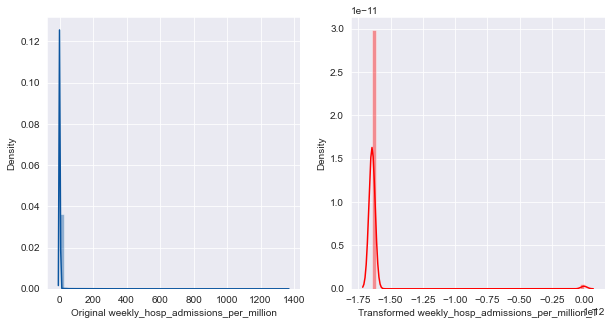


 ------------------------------------------------------

 'new_tests' had 'positive' skewness of 8.92

 Transformation yielded skewness of 0.27


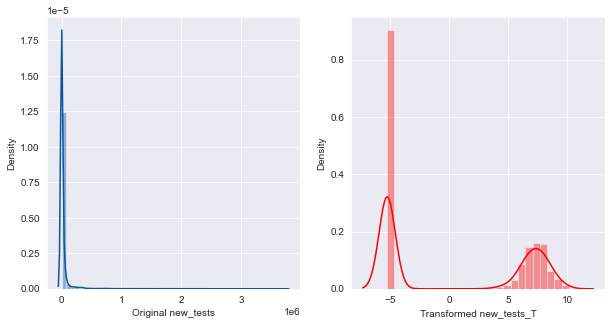


 ------------------------------------------------------

 'total_tests' had 'positive' skewness of 9.34

 Transformation yielded skewness of 0.24


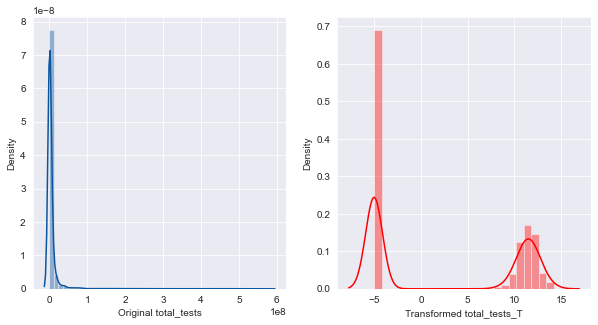


 ------------------------------------------------------

 'total_tests_per_thousand' had 'positive' skewness of 6.27

 Transformation yielded skewness of 0.27


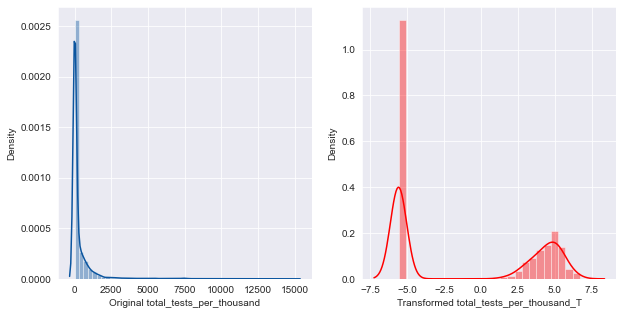


 ------------------------------------------------------

 'new_tests_per_thousand' had 'positive' skewness of 10.89

 Transformation yielded skewness of 0.40


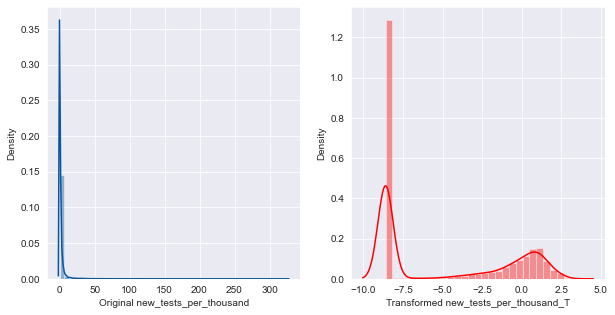


 ------------------------------------------------------

 'new_tests_smoothed' had 'positive' skewness of 8.21

 Transformation yielded skewness of -0.09


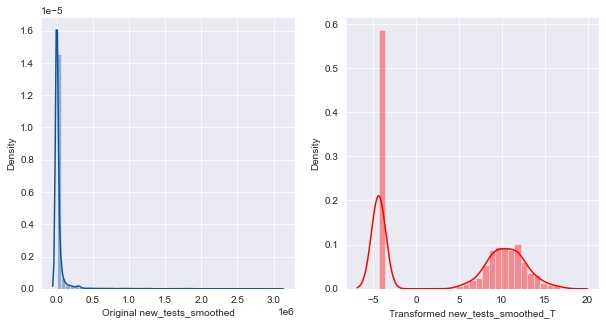


 ------------------------------------------------------

 'new_tests_smoothed_per_thousand' had 'positive' skewness of 7.06

 Transformation yielded skewness of 0.13


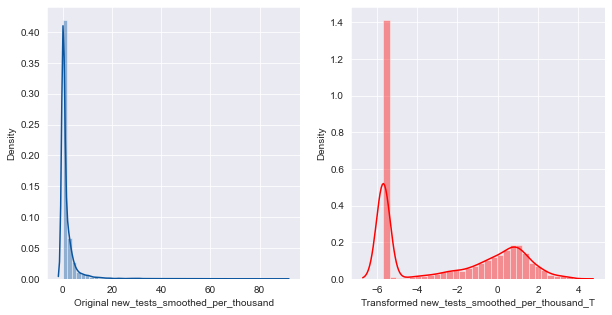


 ------------------------------------------------------

 'positive_rate' had 'positive' skewness of 2.26

 Transformation yielded skewness of 0.36


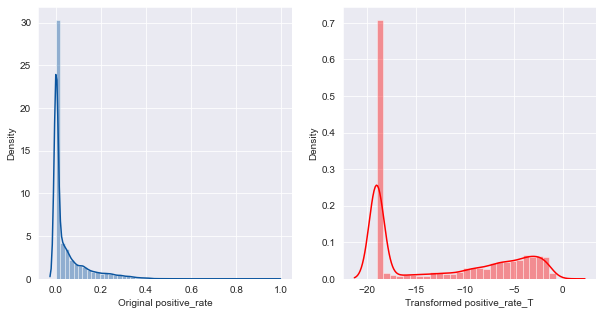


 ------------------------------------------------------

 'tests_per_case' had 'positive' skewness of 24.26

 Transformation yielded skewness of 0.07


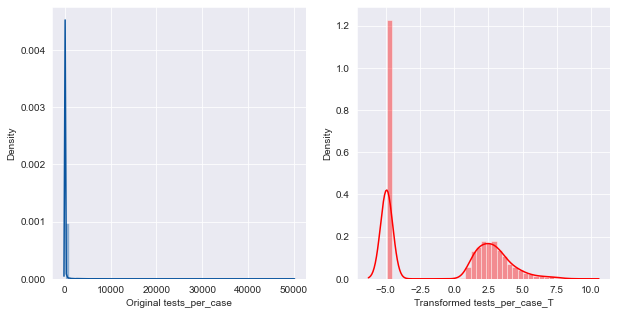


 ------------------------------------------------------

 'total_vaccinations' had 'positive' skewness of 15.05

 Transformation yielded skewness of 0.34


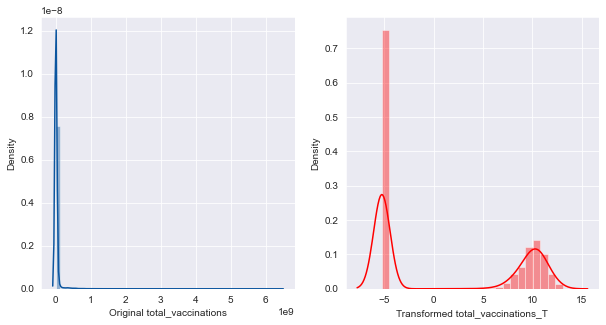


 ------------------------------------------------------

 'people_vaccinated' had 'positive' skewness of 16.66

 Transformation yielded skewness of 0.41


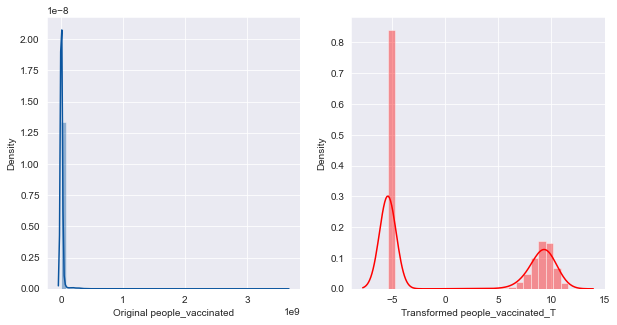


 ------------------------------------------------------

 'people_fully_vaccinated' had 'positive' skewness of 20.34

 Transformation yielded skewness of 0.61


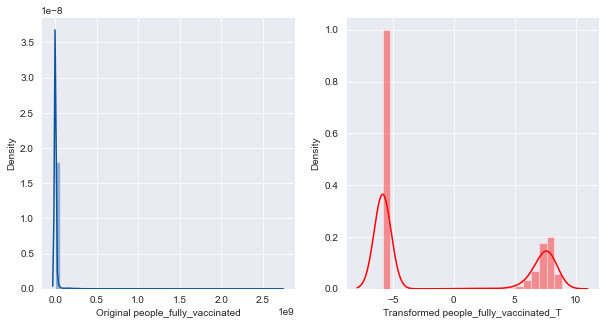


 ------------------------------------------------------

 'total_boosters' had 'positive' skewness of 21.68

 Transformation yielded skewness of 4.17


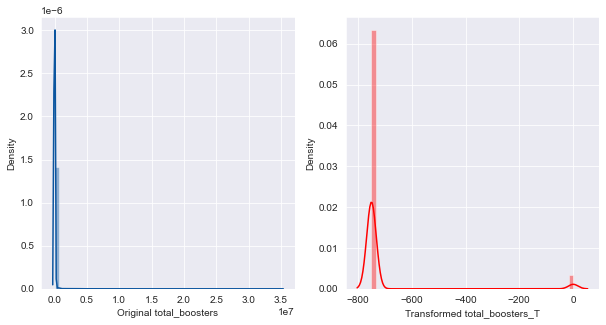


 ------------------------------------------------------

 'new_vaccinations' had 'positive' skewness of 12.46

 Transformation yielded skewness of 0.62


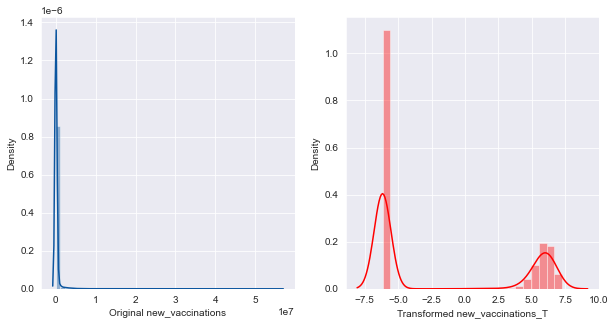


 ------------------------------------------------------

 'new_vaccinations_smoothed' had 'positive' skewness of 12.19

 Transformation yielded skewness of -0.18


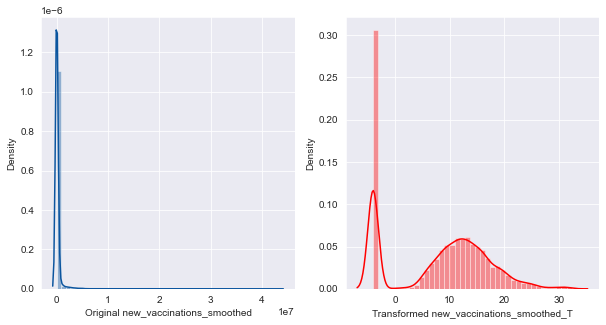


 ------------------------------------------------------

 'total_vaccinations_per_hundred' had 'positive' skewness of 2.20

 Transformation yielded skewness of 0.42


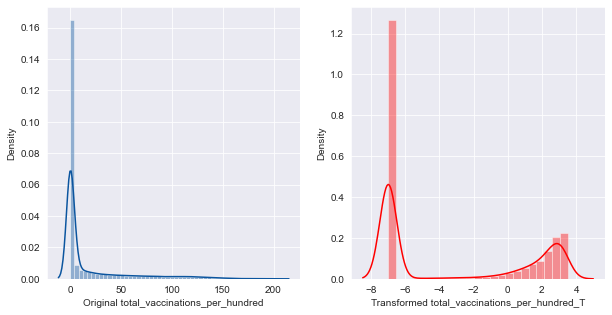


 ------------------------------------------------------

 'people_vaccinated_per_hundred' had 'positive' skewness of 1.96

 Transformation yielded skewness of 0.49


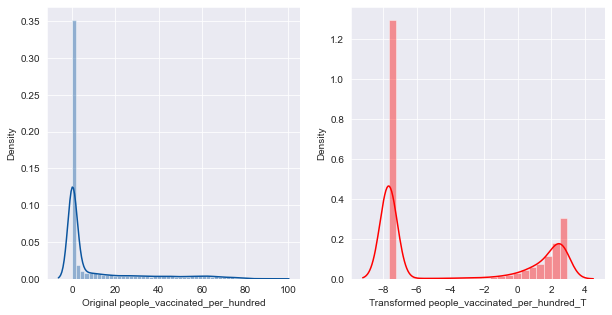


 ------------------------------------------------------

 'people_fully_vaccinated_per_hundred' had 'positive' skewness of 2.60

 Transformation yielded skewness of 0.70


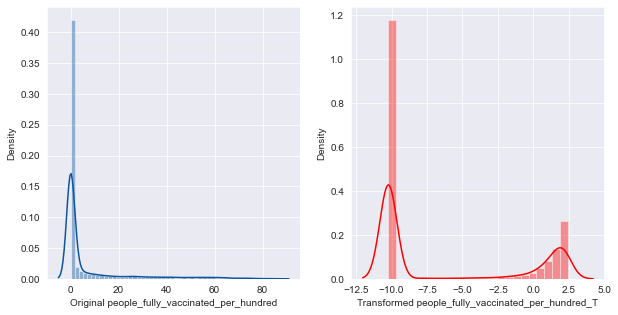


 ------------------------------------------------------

 'total_boosters_per_hundred' had 'positive' skewness of 20.82

 Transformation yielded skewness of 5.68


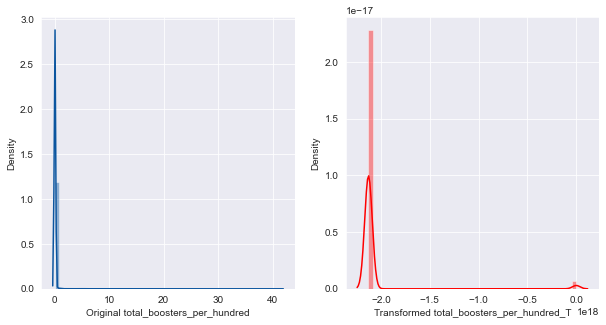


 ------------------------------------------------------

 'new_vaccinations_smoothed_per_million' had 'positive' skewness of 5.44

 Transformation yielded skewness of -0.41


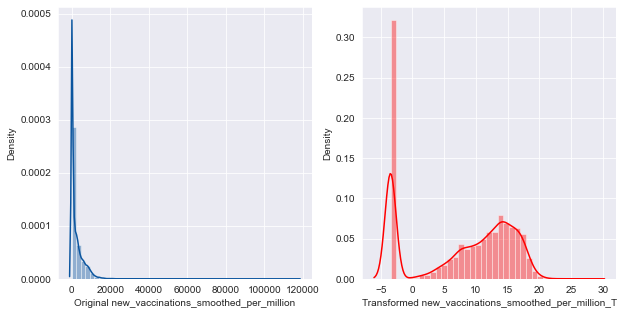


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'stringency_index' . Skewness = -0.54


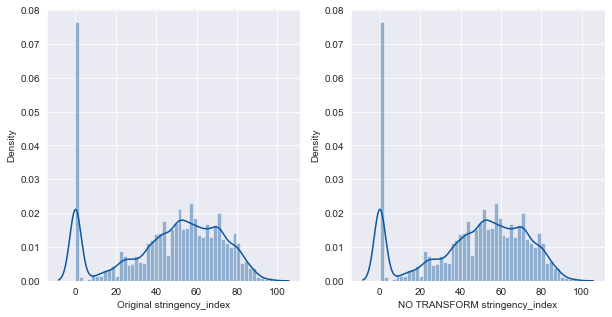


 ------------------------------------------------------

 'population' had 'positive' skewness of 9.60

 Transformation yielded skewness of 0.18


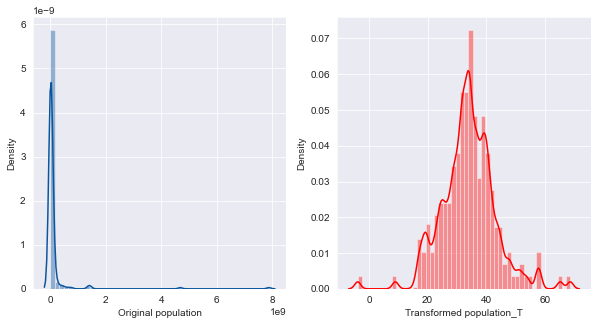


 ------------------------------------------------------

 'population_density' had 'positive' skewness of 10.20

 Transformation yielded skewness of 0.26


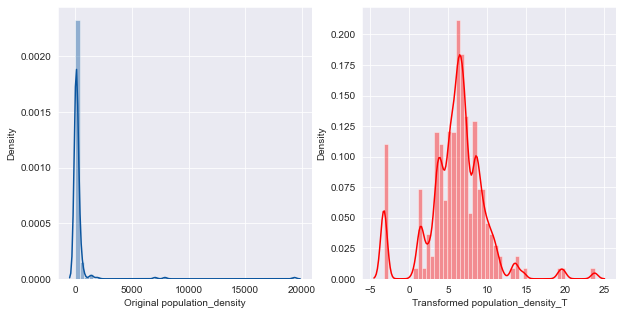


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'median_age' . Skewness = -0.60


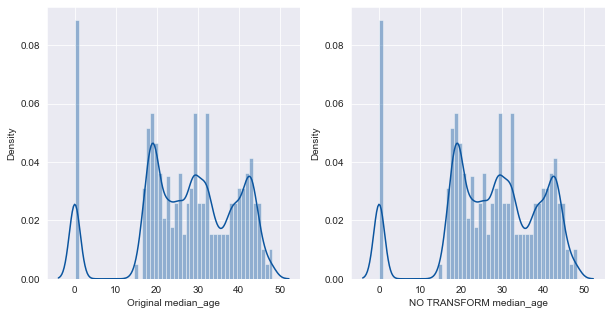


 ------------------------------------------------------

 'aged_65_older' had 'positive' skewness of 0.84

 Transformation yielded skewness of -0.27


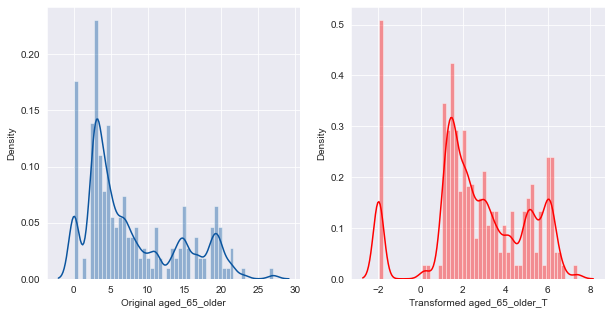


 ------------------------------------------------------

 'aged_70_older' had 'positive' skewness of 0.99

 Transformation yielded skewness of -0.19


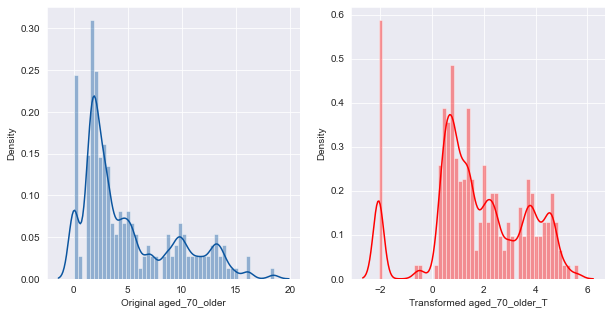


 ------------------------------------------------------

 'gdp_per_capita' had 'positive' skewness of 1.92

 Transformation yielded skewness of -0.40


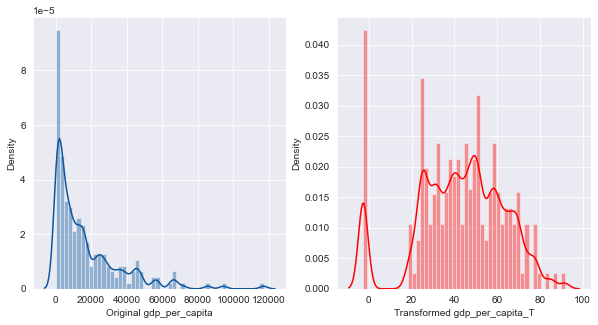


 ------------------------------------------------------

 'extreme_poverty' had 'positive' skewness of 2.31

 Transformation yielded skewness of 0.06


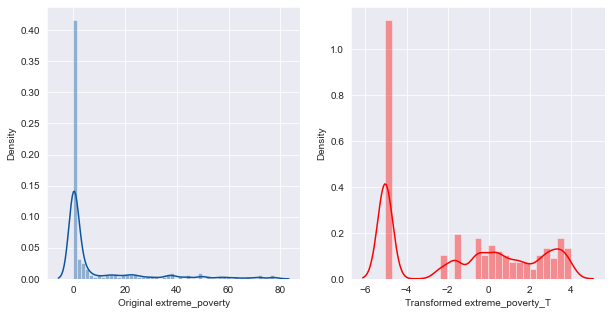


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'cardiovasc_death_rate' . Skewness = 0.43


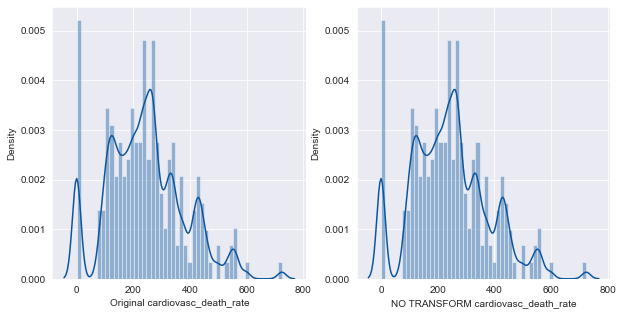


 ------------------------------------------------------

 'diabetes_prevalence' had 'positive' skewness of 1.14

 Transformation yielded skewness of -0.17


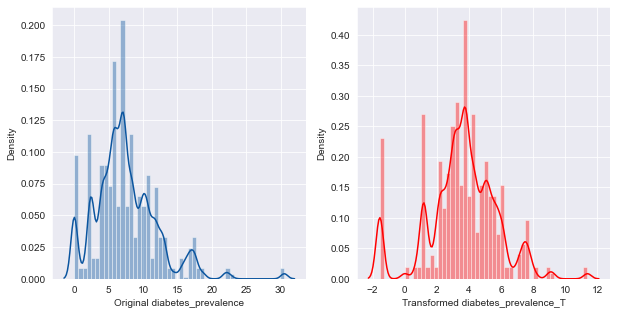


 ------------------------------------------------------

 'female_smokers' had 'positive' skewness of 1.40

 Transformation yielded skewness of -0.22


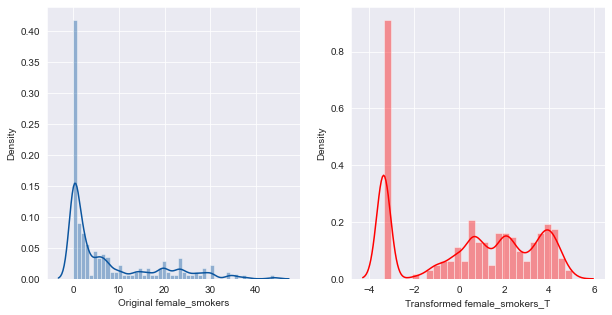


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'male_smokers' . Skewness = 0.25


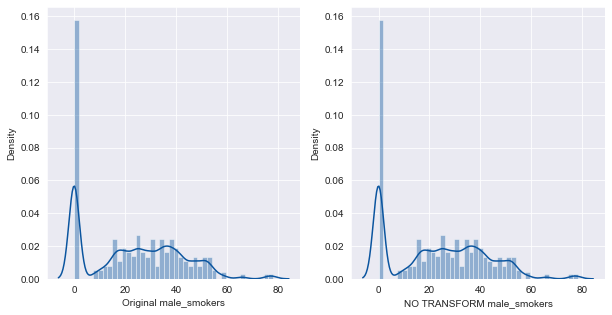


 ------------------------------------------------------

 'handwashing_facilities' had 'positive' skewness of 1.06

 Transformation yielded skewness of 0.15


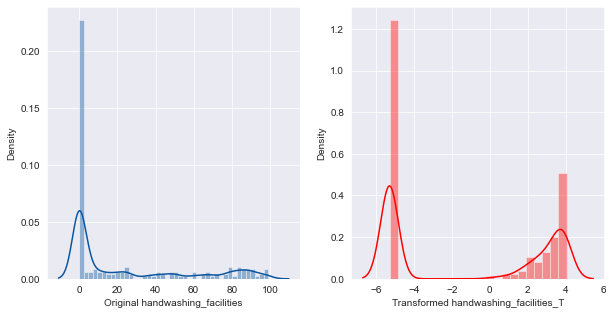


 ------------------------------------------------------

 'hospital_beds_per_thousand' had 'positive' skewness of 1.70

 Transformation yielded skewness of -0.28


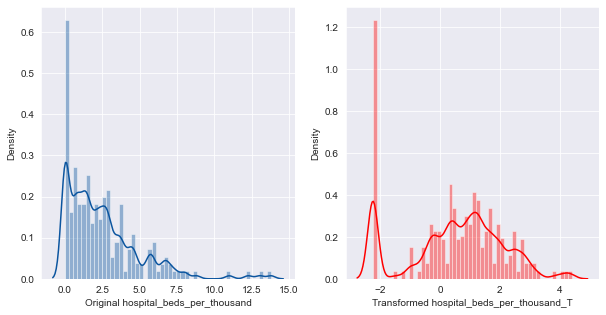


 ------------------------------------------------------

 'life_expectancy' had 'negative' skewness of -3.12

 Transformation yielded skewness of -2.14


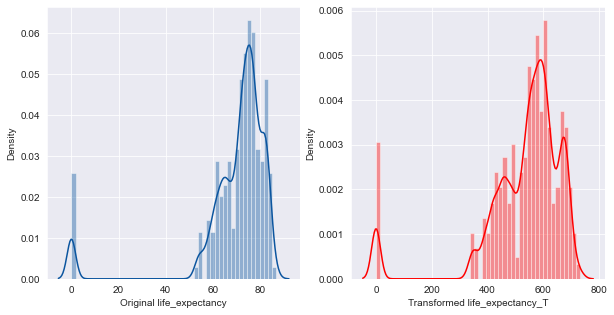


 ------------------------------------------------------

 'human_development_index' had 'negative' skewness of -1.47

 Transformation yielded skewness of -0.85


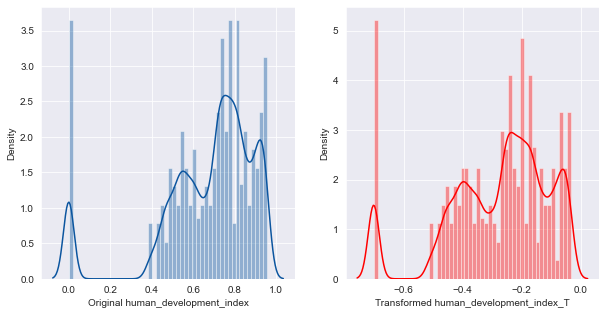


 ------------------------------------------------------

 'excess_mortality_cumulative_absolute' had 'positive' skewness of 22.14

 Transformation yielded skewness of 0.19


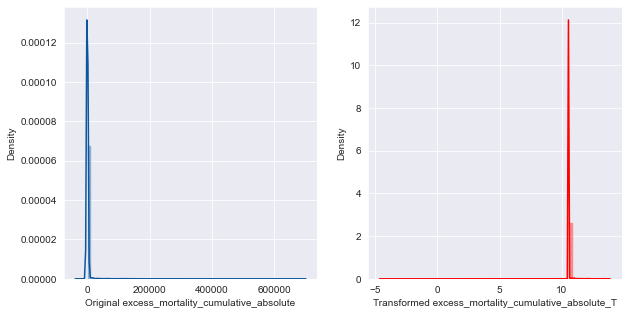


 ------------------------------------------------------

 'excess_mortality_cumulative' had 'positive' skewness of 15.24

 Transformation yielded skewness of -0.48


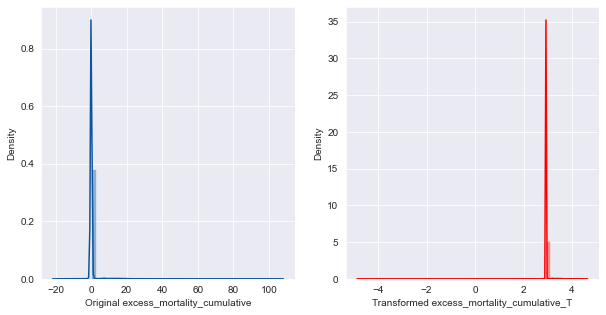


 ------------------------------------------------------

 'excess_mortality' had 'positive' skewness of 18.96

 Transformation yielded skewness of 1.23


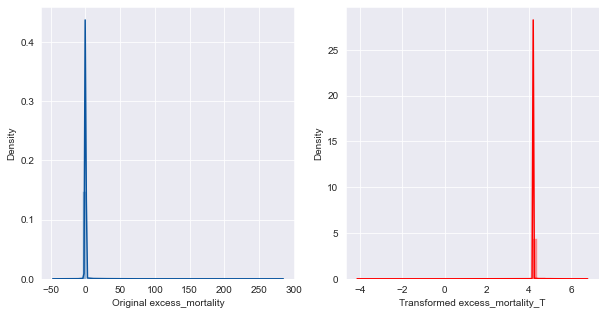


 ------------------------------------------------------

 'excess_mortality_cumulative_per_million' had 'positive' skewness of 9.42

 Transformation yielded skewness of 1.55


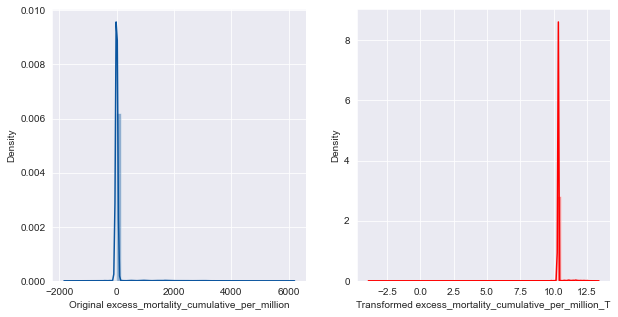


 ------------------------------------------------------

 'continent_Africa' had 'positive' skewness of 1.01

 Transformation yielded skewness of 1.01


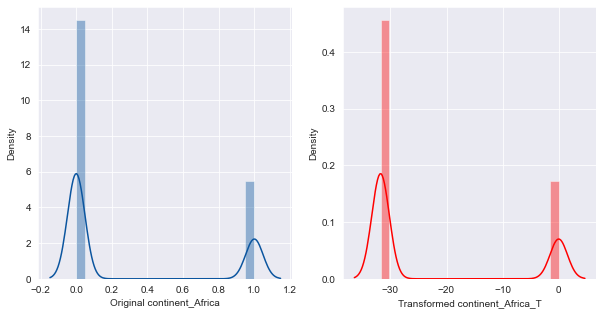


 ------------------------------------------------------

 'continent_Asia' had 'positive' skewness of 1.22

 Transformation yielded skewness of 1.22


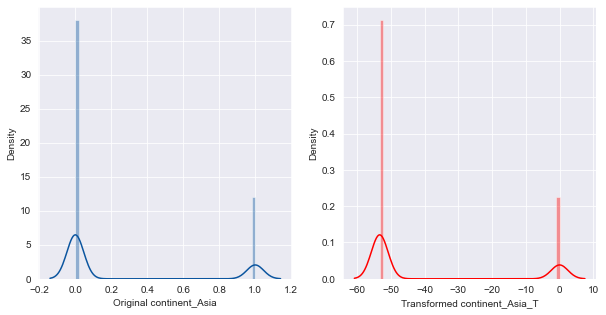


 ------------------------------------------------------

 'continent_Europe' had 'positive' skewness of 1.22

 Transformation yielded skewness of 1.22


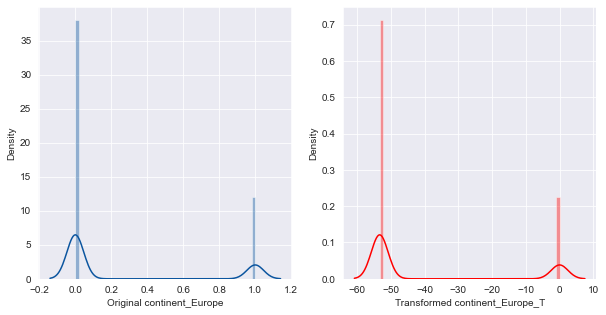


 ------------------------------------------------------

 'continent_North America' had 'positive' skewness of 2.34

 Transformation yielded skewness of 2.34


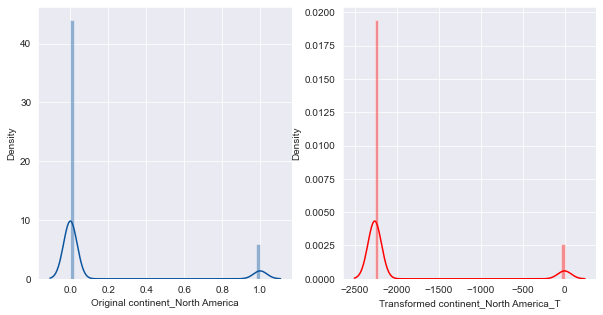


 ------------------------------------------------------

 'continent_Oceania' had 'positive' skewness of 4.03

 Transformation yielded skewness of 4.03


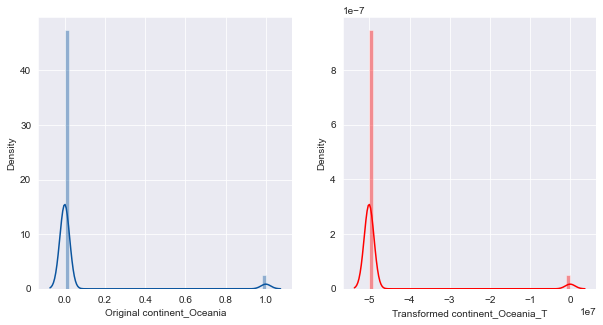


 ------------------------------------------------------

 'continent_South America' had 'positive' skewness of 3.53

 Transformation yielded skewness of 3.53


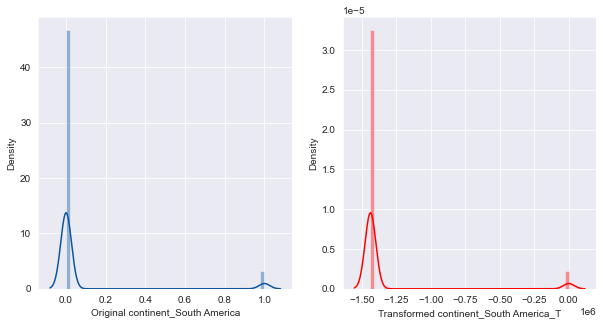


 ------------------------------------------------------

 'continent_World' had 'positive' skewness of 9.86

 Transformation yielded skewness of 9.86


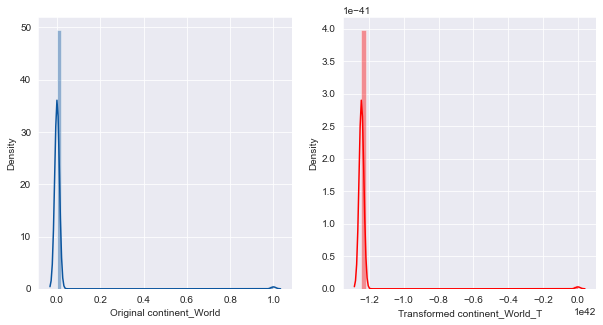


 ------------------------------------------------------

 'tests_units_people tested' had 'positive' skewness of 2.52

 Transformation yielded skewness of 2.52


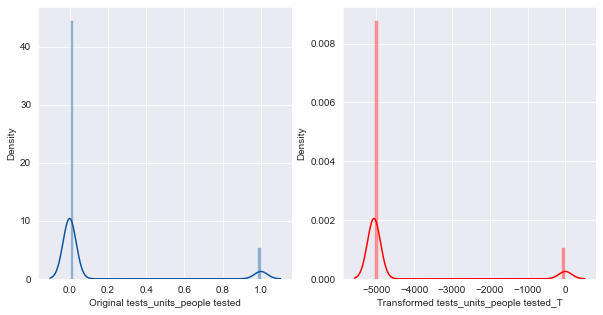


 ------------------------------------------------------

 'tests_units_samples tested' had 'positive' skewness of 2.81

 Transformation yielded skewness of 2.81


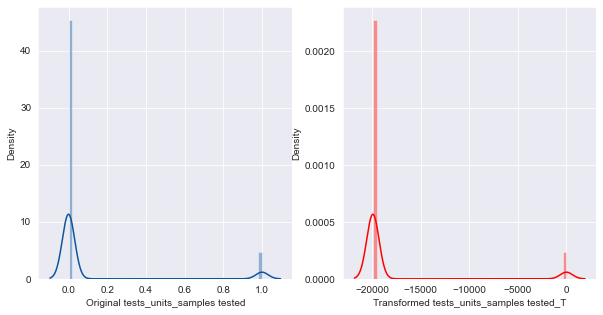


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_tests performed' . Skewness = 0.58


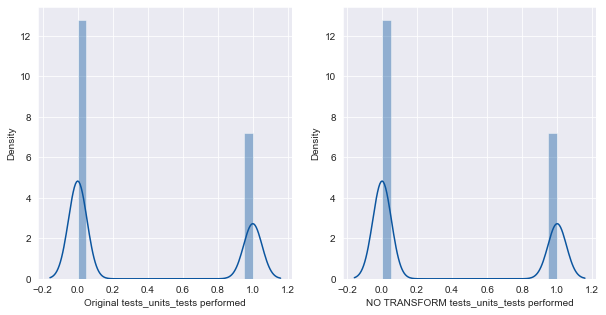


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'tests_units_units unclear' . Skewness = 0.25


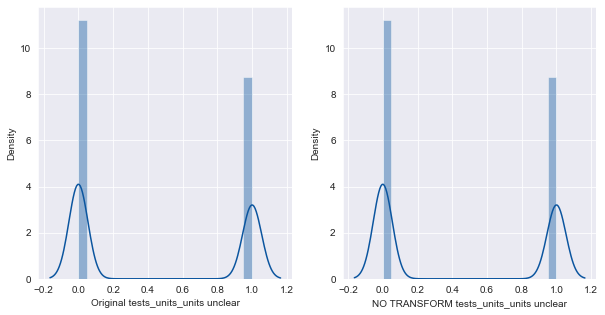

Skew AFTER Transform:
total_cases                                  10.982123
new_cases                                    10.279626
new_cases_smoothed                           10.077248
total_deaths                                 10.910948
new_deaths                                   10.301086
new_deaths_smoothed                          9.867136 
total_cases_per_million                      1.534302 
new_cases_per_million                        5.423362 
new_cases_smoothed_per_million               3.627918 
total_deaths_per_million                     2.123739 
new_deaths_per_million                       9.078775 
new_deaths_smoothed_per_million              4.313778 
reproduction_rate                           -0.708064 
icu_patients                                 16.002244
icu_patients_per_million                     5.131077 
hosp_patients                                13.971399
hosp_patients_per_million                    5.748868 
weekly_icu_admissions                      

In [290]:
#After Vaccine Correction for Skew Using BoxCox transform for any skew value over 0.8
print("Skew BEFORE Transform:")
print(after_vax.skew())

after_vax_boxT = after_vax
skew_autotransform(after_vax_boxT, exclude = ['location','tests_units','date'], plot = True, threshold = 0.8, exp = False)
after_vax = pd.read_csv('after_vaccination_w_continents_dummy.csv')

print("Skew AFTER Transform:")
print(after_vax_boxT.skew())

In [23]:
after_vax_boxT.tail().T
after_vax_boxT.to_csv('after_vax_feature_transforms.csv')

In [24]:
###########################
#correlation of features against target
###########################

target = "new_deaths_smoothed_per_million"
    
corr_matrix = before_vax.corr()
cor_matrics_abs = corr_matrix[[target]].abs()
corr_matrix[target+"_abs"] = cor_matrics_abs

corr_w_target = corr_matrix[[target,target+"_abs"]].sort_values(target+"_abs", axis=0, ascending=False)


print(corr_w_target[target].head(30)) #Top 30 correlated features with target


new_deaths_smoothed_per_million            1.000000
new_deaths_per_million                     0.750066
new_cases_smoothed_per_million             0.560580
total_deaths_per_million                   0.501053
hosp_patients_per_million                  0.478530
icu_patients_per_million                   0.466134
total_cases_per_million                    0.444548
new_cases_per_million                      0.441674
positive_rate                              0.389578
hosp_patients                              0.241622
excess_mortality                           0.217847
continent_Europe                           0.205799
continent_South America                    0.198874
female_smokers                             0.190447
continent_Africa                          -0.177576
icu_patients                               0.171063
new_deaths_smoothed                        0.168134
tests_units_tests performed                0.164933
new_deaths                                 0.163616
aged_70_olde

In [25]:
###########################
#correlation of features against target
###########################

target = "new_deaths_smoothed_per_million"
    
corr_matrix = after_vax[after_vax['total_vaccinations'] > 1].corr()
cor_matrics_abs = corr_matrix[[target]].abs()
corr_matrix[target+"_abs"] = cor_matrics_abs

corr_w_target = corr_matrix[[target,target+"_abs"]].sort_values(target+"_abs", axis=0, ascending=False)


print(corr_w_target[target].head(30)) #Top 30 correlated features with target




new_deaths_smoothed_per_million            1.000000
new_deaths_per_million                     0.832400
new_cases_smoothed_per_million             0.595711
new_cases_per_million                      0.507579
hosp_patients_per_million                  0.485026
total_deaths_per_million                   0.396526
positive_rate                              0.390766
icu_patients_per_million                   0.294286
continent_South America                    0.284568
total_cases_per_million                    0.241180
continent_Asia                            -0.212479
female_smokers                             0.203581
excess_mortality                           0.194621
total_vaccinations_per_hundred            -0.184600
hosp_patients                              0.173532
people_fully_vaccinated_per_hundred       -0.158408
continent_Europe                           0.158033
stringency_index                           0.156202
people_vaccinated_per_hundred             -0.156146
aged_65_olde

In [26]:
# evaluate an lasso regression model on the dataset
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso



before_vax_gtm = before_vax.drop(['date'], axis=1).fillna(0)

X = before_vax_gtm.loc[:, before_vax_gtm.columns != 'hosp_patients_per_million']
y = before_vax_gtm.loc[:, before_vax_gtm.columns == 'hosp_patients_per_million']

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.5)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


MAE: -8.081
Config: {'alpha': 0.5}


In [27]:
before_vax_gtm = before_vax.drop(['date'], axis=1).fillna(0)

X = before_vax_gtm.loc[:, before_vax_gtm.columns != 'hosp_patients_per_million']
y = before_vax_gtm.loc[:, before_vax_gtm.columns == 'hosp_patients_per_million']

# Build lasso and fit
scaler = MinMaxScaler()
columns = X.columns
#X_1 = scaler.fit_transform(X) #mix max scaler to bound ranges of features between 1 and 0
#X_1 = pd.DataFrame(X_1, columns = columns)

lasso = model.fit(X,y)

# Read out coefficients into sorted table:
coeffs = lasso.coef_ 
feature_importance = pd.DataFrame({'variable':X.columns,
              'coefficient':lasso.coef_})

feature_importance.sort_values(by=['coefficient'],ascending=False)

variable   coefficient
14  icu_patients_per_million                 3.962533e+00
11  new_deaths_smoothed_per_million          1.074774e+00
23  new_tests_per_thousand                   5.857176e-01
41  hospital_beds_per_thousand               3.329448e-01
38  female_smokers                           2.417507e-01
33  aged_70_older                            2.362890e-01
10  new_deaths_per_million                   2.029339e-01
19  weekly_hosp_admissions_per_million       1.920844e-01
32  aged_65_older                            9.223803e-02
46  excess_mortality                         8.506004e-02
8   new_cases_smoothed_per_million           8.239574e-02
35  extreme_poverty                          2.125581e-02
15  hosp_patients                            1.902941e-02
36  cardiovasc_death_rate                    1.230180e-02
22  total_tests_per_thousand                 1.046712e-02
4   new_deaths                               1.727676e-04
44  excess_mortality_cumulative_absolute     1.275885e-04
3   total_deaths                             3.190731e-05
34  gdp_per_capita                           2.815148e-05
24  new_tests_smoothed                       2.251734e-05
0   total_cases                              1.286763e-06
21  total_tests                              8.381554e-08
29  population                               1.456697e-09
58  tests_units_units unclear               -0.000000e+00
54  continent_World                          0.000000e+00
48  continent_Africa                         0.000000e+00
49  continent_Asia                          -0.000000e+00
50  continent_Europe                        -0.000000e+00
51  continent_North America                  0.000000e+00
52  continent_Oceania                       -0.000000e+00
12  reproduction_rate                       -0.000000e+00
53  continent_South America                 -0.000000e+00
17  weekly_icu_admissions_per_million        0.000000e+00
43  human_development_index                 -0.000000e+00
31  median_age                               0.000000e+00
55  tests_units_people tested               -0.000000e+00
56  tests_units_samples tested              -0.000000e+00
57  tests_units_tests performed              0.000000e+00
26  positive_rate                            0.000000e+00
25  new_tests_smoothed_per_thousand          0.000000e+00
45  excess_mortality_cumulative             -0.000000e+00
1   new_cases                               -1.607067e-05
20  new_tests                               -2.963292e-05
27  tests_per_case                          -1.140736e-04
30  population_density                      -1.612082e-04
2   new_cases_smoothed                      -1.889994e-04
6   total_cases_per_million                 -1.916309e-04
7   new_cases_per_million                   -3.462172e-04
18  weekly_hosp_admissions                  -2.001869e-03
5   new_deaths_smoothed                     -2.674552e-03
28  stringency_index                        -3.934993e-03
47  excess_mortality_cumulative_per_million -8.881860e-03
40  handwashing_facilities                  -1.396391e-02
9   total_deaths_per_million                -1.619921e-02
16  weekly_icu_admissions                   -3.393901e-02
42  life_expectancy                         -4.139099e-02
39  male_smokers                            -6.905162e-02
13  icu_patients                            -7.480004e-02
37  diabetes_prevalence                     -2.485692e-01

In [28]:
# evaluate an lasso regression model on the dataset
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso


after_vax_gtm = after_vax.drop(['date'], axis=1).fillna(0)

X = after_vax_gtm.loc[:, after_vax_gtm.columns != 'hosp_patients_per_million']
y = after_vax_gtm.loc[:, after_vax_gtm.columns == 'hosp_patients_per_million']

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.5)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


MAE: -24.415
Config: {'alpha': 0.5}


In [76]:
# Build lasso and fit

after_vax_gtm = after_vax.drop(['date'], axis=1).fillna(0)

X = after_vax_gtm.loc[:, after_vax_gtm.columns != 'hosp_patients_per_million']
y = after_vax_gtm.loc[:, after_vax_gtm.columns == 'hosp_patients_per_million']

columns = X.columns
#X_1 = scaler.fit_transform(X) #mix max scaler to bound ranges of features between 1 and 0
#X_1 = pd.DataFrame(X_1, columns = columns)

lasso = model.fit(X,y)

# Read out coefficients into sorted table:
coeffs = lasso.coef_         # dense np.array
feature_importance = pd.DataFrame({'variable':X.columns,
              'coefficient':lasso.coef_})

feature_importance.sort_values(by=['coefficient'],ascending=False)

variable   coefficient
11  new_deaths_smoothed_per_million          6.441308e+00
14  icu_patients_per_million                 3.949576e+00
44  aged_70_older                            3.236881e+00
25  new_tests_smoothed_per_thousand          1.941647e+00
52  hospital_beds_per_thousand               1.699839e+00
49  female_smokers                           1.119881e+00
23  new_tests_per_thousand                   1.108096e+00
57  excess_mortality                         3.850491e-01
17  weekly_icu_admissions_per_million        2.966129e-01
19  weekly_hosp_admissions_per_million       2.320373e-01
47  cardiovasc_death_rate                    6.510219e-02
34  total_vaccinations_per_hundred           4.758162e-02
46  extreme_poverty                          3.585644e-02
15  hosp_patients                            2.322878e-02
58  excess_mortality_cumulative_per_million  2.277642e-02
39  stringency_index                         1.535867e-02
7   new_cases_per_million                    2.685046e-03
4   new_deaths                               7.313838e-04
45  gdp_per_capita                           1.894317e-04
2   new_cases_smoothed                       1.122936e-04
0   total_cases                              3.321548e-06
31  total_boosters                           1.456598e-06
21  total_tests                              3.918056e-07
32  new_vaccinations                         1.774983e-07
40  population                               2.805311e-09
28  total_vaccinations                       6.630416e-10
54  human_development_index                 -0.000000e+00
60  continent_Asia                           0.000000e+00
61  continent_Europe                         0.000000e+00
62  continent_North America                  0.000000e+00
63  continent_Oceania                       -0.000000e+00
64  continent_South America                 -0.000000e+00
65  continent_World                          0.000000e+00
66  tests_units_people tested                0.000000e+00
67  tests_units_samples tested               0.000000e+00
68  tests_units_tests performed              0.000000e+00
59  continent_Africa                         0.000000e+00
35  people_vaccinated_per_hundred            0.000000e+00
69  tests_units_units unclear               -0.000000e+00
26  positive_rate                            0.000000e+00
10  new_deaths_per_million                   0.000000e+00
12  reproduction_rate                       -0.000000e+00
37  total_boosters_per_hundred               0.000000e+00
30  people_fully_vaccinated                 -2.516542e-08
29  people_vaccinated                       -3.258373e-08
33  new_vaccinations_smoothed               -1.020378e-06
41  population_density                      -2.446872e-06
1   new_cases                               -5.450622e-05
20  new_tests                               -5.827913e-05
24  new_tests_smoothed                      -7.158670e-05
55  excess_mortality_cumulative_absolute    -1.112631e-04
3   total_deaths                            -1.121072e-04
6   total_cases_per_million                 -2.212245e-04
38  new_vaccinations_smoothed_per_million   -5.003805e-04
18  weekly_hosp_admissions                  -1.004372e-03
9   total_deaths_per_million                -1.263623e-03
27  tests_per_case                          -1.829026e-03
8   new_cases_smoothed_per_million          -5.206047e-03
22  total_tests_per_thousand                -8.697101e-03
5   new_deaths_smoothed                     -1.335698e-02
51  handwashing_facilities                  -6.700637e-02
13  icu_patients                            -9.554276e-02
36  people_fully_vaccinated_per_hundred     -1.068489e-01
16  weekly_icu_admissions                   -1.069313e-01
50  male_smokers                            -1.288226e-01
53  life_expectancy                         -1.908253e-01
43  aged_65_older                           -4.848611e-01
42  median_age                              -5.008088e-01
48  diabetes_prevalence          

What trends do we see in the spread of COVID-19, hospitalizations and deaths before and after the development of the vaccine? 

How effective are the vaccines in curbing the spread of the virus? 

What demographics are more likely to receive the vaccine in the US? 

Which vaccination has been administered the most globally? 

Percentage of people vaccinated in the US by age group.

### AFTER VAX MODELS

In [ ]:
#after vax raw
after_vax_gtm = after_vax_selection.drop(['date',
                                          'new_deaths_per_million',
                                          'new_deaths_smoothed',
                                          #'new_deaths_smoothed_per_million',
                                          'new_deaths',
                                          'total_deaths_per_million',
                                          'total_deaths',
                                          'excess_mortality',
                                          'excess_mortality_cumulative',
                                          'excess_mortality_cumulative_per_million',
                                          'excess_mortality_cumulative_absolute'
                                         ], axis=1).fillna(0)

RAW = after_vax_gtm[['new_cases_smoothed_per_million',
       #'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million',
       'new_tests_smoothed_per_thousand',
       'positive_rate',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',
       'continent_Africa', 'continent_Asia', 'continent_Europe',
       'continent_North America', 'continent_Oceania',
       'continent_South America', 'continent_World',
       'tests_units_people tested', 'tests_units_samples tested',
       'tests_units_tests performed', 'tests_units_units unclear']]

#after_vax_selection1 = after_vax_boxT[(np.abs(stats.zscore(after_vax_boxT)) < 3).all(axis=1)]

In [799]:
###########################
#test train split
###########################

#'new_deaths_smoothed'
#'new_deaths_smoothed_per_million'

#after_vax_selection = after_vax 

#remove outliers
after_vax_selection1 = after_vax_boxT[(np.abs(stats.zscore(after_vax_boxT['new_cases_smoothed_per_million_T'])) < 3)]
#model on only rows/days where vaccines were available
after_vax_selection = after_vax_selection1[after_vax_selection1['total_vaccinations'] > 0]


#remove target variables from model
after_vax_gtm_T = after_vax_selection.drop(['date',
                                          'new_deaths_per_million',
                                          'new_deaths_smoothed',
                                          #'new_deaths_smoothed_per_million',
                                          'new_deaths',
                                          'total_deaths_per_million',
                                          'total_deaths',
                                          'excess_mortality',
                                          'excess_mortality_cumulative',
                                          'excess_mortality_cumulative_per_million',
                                          'excess_mortality_cumulative_absolute',
                                          'new_deaths_per_million_T',
                                          'new_deaths_smoothed_T',
                                          #'new_deaths_smoothed_per_million_T',
                                          'new_deaths_T',
                                          'total_deaths_per_million_T',
                                          'total_deaths_T',
                                          'excess_mortality_T',
                                          'excess_mortality_cumulative_T',
                                          'excess_mortality_cumulative_per_million_T',
                                          'excess_mortality_cumulative_absolute_T'
                                         ], axis=1).fillna(0)

#select features for the model
transformed_variables = after_vax_gtm_T[['new_cases_smoothed_per_million_T',
       #'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million_T',
       'new_tests_smoothed_per_thousand_T',
       'positive_rate_T',
       'total_vaccinations_per_hundred_T', 'people_vaccinated_per_hundred_T',
       'people_fully_vaccinated_per_hundred_T', 'total_boosters_per_hundred_T',
       'new_vaccinations_smoothed_per_million_T', #'stringency_index_T',
       'population_T', 'population_density_T', #'median_age_T', #'aged_65_older',
       'aged_70_older_T', 'gdp_per_capita_T', 'extreme_poverty_T',
       'diabetes_prevalence_T', 'female_smokers_T',
       'handwashing_facilities_T', 'hospital_beds_per_thousand_T',
       'life_expectancy_T', 'human_development_index_T',
       'continent_Africa_T', 'continent_Asia_T', 'continent_Europe_T',
       'continent_North America_T', 'continent_Oceania_T',
       'continent_South America_T', 'continent_World_T',
       'tests_units_people tested_T', #'tests_units_samples tested_T',
       #'tests_units_tests performed_T', 'tests_units_units unclear_T'
        'stringency_index','median_age','aged_65_older'
                     ]]

#X = after_vax_gtm.loc[:, after_vax_gtm.columns != 'new_deaths_smoothed_per_million']
y = after_vax_gtm.loc[:, after_vax_gtm.columns == 'new_deaths_smoothed_per_million_T']

X = transformed_variables

columns = X.columns
scaler.fit(X)
X = scaler.transform(X)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(21017, 31)
(21017, 1)
(5255, 31)
(5255, 1)


In [795]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class

LR = LinearRegression()
# fitting the training data
LR.fit(X_train,y_train)

y_prediction =  LR.predict(X_test)

# importing allr2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score = r2_score(y_test,y_prediction)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))

# Read out coefficients into sorted table:
print("")
print("Intercept is== ", LR.intercept_)

coeffs = LR.coef_         # dense np.array
feature_importance = pd.DataFrame({'variable':columns,
              'coefficient':(LR.coef_).flatten()})

feature_importance.sort_values(by=['coefficient'],ascending=False)

r2 socre is  0.7041824843451971
mean_sqrd_error is== 0.025227290002243573
root_mean_squared error of is== 0.15883101083303466

Intercept is==  [0.76436791]


variable  coefficient
0   new_cases_smoothed_per_million_T         1.047561   
29  median_age                               0.230709   
14  diabetes_prevalence_T                    0.227762   
11  aged_70_older_T                          0.191349   
28  stringency_index                         0.158518   
25  continent_South America_T                0.148116   
17  hospital_beds_per_thousand_T             0.136158   
13  extreme_poverty_T                        0.082250   
8   new_vaccinations_smoothed_per_million_T  0.069387   
6   people_fully_vaccinated_per_hundred_T    0.069117   
9   population_T                             0.067418   
3   positive_rate_T                          0.065168   
22  continent_Europe_T                       0.040521   
27  tests_units_people tested_T              0.025190   
5   people_vaccinated_per_hundred_T          0.017235   
26  continent_World_T                        0.010047   
23  continent_North America_T                0.001811   
10  population_density_T                    -0.008201   
16  handwashing_facilities_T                -0.019970   
24  continent_Oceania_T                     -0.030923   
1   weekly_hosp_admissions_per_million_T    -0.037386   
15  female_smokers_T                        -0.041214   
2   new_tests_smoothed_per_thousand_T       -0.051402   
19  human_development_index_T               -0.055619   
7   total_boosters_per_hundred_T            -0.057275   
20  continent_Africa_T                      -0.075143   
21  continent_Asia_T                        -0.094430   
12  gdp_per_capita_T                        -0.121772   
30  aged_65_older                           -0.194390   
4   total_vaccinations_per_hundred_T        -0.303109   
18  life_expectancy_T                       -0.466705

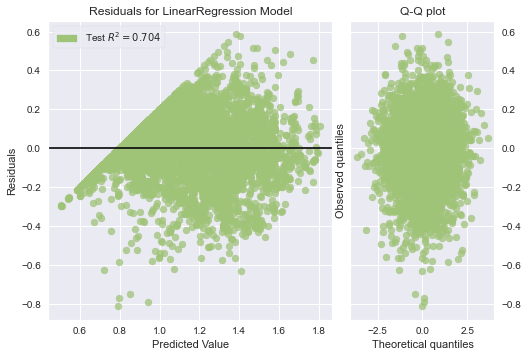

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [796]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

visualizer1 = ResidualsPlot(LR, hist=False, qqplot=True)
#visualizer1.fit(X_train, y_train)
visualizer1.score(X_test, y_test)
visualizer1.show()

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

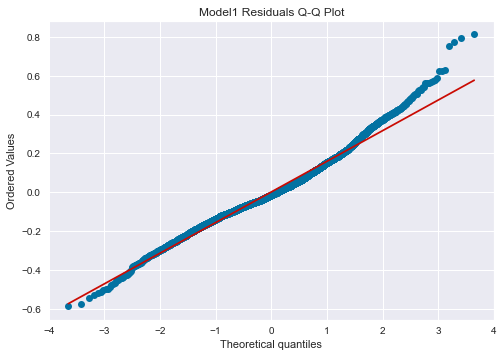

In [797]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt

residual = y_test - y_prediction
stats.probplot(residual['new_deaths_smoothed_per_million_T'], dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

TypeError: missing a required argument: 'y'

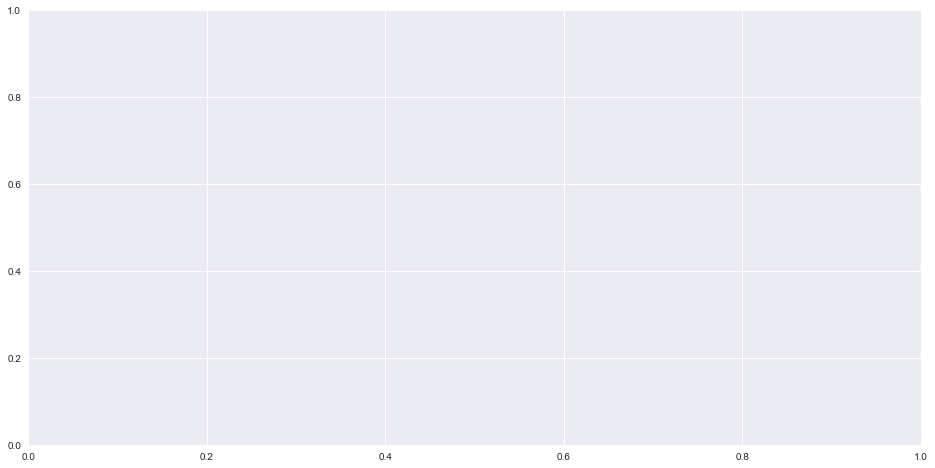

In [659]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(after_vax_gtm_T['new_deaths_smoothed_per_million_T'])

In [655]:
# evaluate an ridge regression model on the dataset
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso


# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0,1,.05)
# define search
search = GridSearchCV(model, grid, scoring = 'r2', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

best_model = Lasso(alpha=results.best_index_)
best_model.fit(X_train,y_train)
y_prediction =  best_model.predict(X_test)
y_prediction

score = r2_score(y_test,y_prediction)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))



# Read out coefficients into sorted table:
feature_importance = pd.DataFrame({'variable':columns,
              'coefficient':best_model.coef_})

feature_importance.sort_values(by=['coefficient'],ascending=False)

MAE: 0.580
Config: {'alpha': 0.0}
r2 socre is  0.6985097689718773
mean_sqrd_error is== 0.025741668679910228
root_mean_squared error of is== 0.1604421038253682


variable  coefficient
0   new_cases_smoothed_per_million_T         8.861612   
29  median_age                               0.231605   
14  diabetes_prevalence_T                    0.225258   
28  stringency_index                         0.168637   
11  aged_70_older_T                          0.155269   
8   new_vaccinations_smoothed_per_million_T  0.123016   
17  hospital_beds_per_thousand_T             0.119768   
25  continent_South America_T                0.115713   
3   positive_rate_T                          0.115132   
6   people_fully_vaccinated_per_hundred_T    0.072419   
13  extreme_poverty_T                        0.059754   
9   population_T                             0.024966   
27  tests_units_people tested_T              0.013040   
5   people_vaccinated_per_hundred_T          0.009696   
26  continent_World_T                        0.009393   
22  continent_Europe_T                       0.004950   
15  female_smokers_T                        -0.007824   
10  population_density_T                    -0.026849   
16  handwashing_facilities_T                -0.030064   
23  continent_North America_T               -0.036577   
1   weekly_hosp_admissions_per_million_T    -0.038027   
7   total_boosters_per_hundred_T            -0.060931   
2   new_tests_smoothed_per_thousand_T       -0.073488   
19  human_development_index_T               -0.073919   
12  gdp_per_capita_T                        -0.093953   
24  continent_Oceania_T                     -0.117952   
20  continent_Africa_T                      -0.138477   
21  continent_Asia_T                        -0.143388   
30  aged_65_older                           -0.173066   
4   total_vaccinations_per_hundred_T        -0.328202   
18  life_expectancy_T                       -0.475836

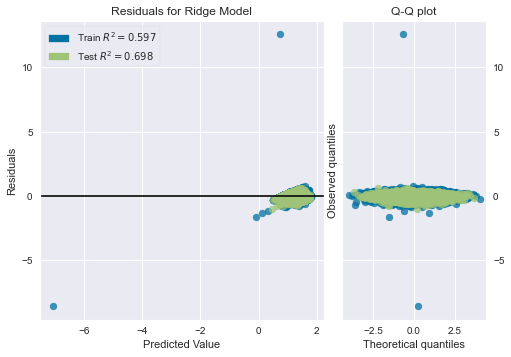

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [658]:
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

model = Ridge(alpha=results.best_index_)
visualizer2 = ResidualsPlot(model, hist=False, qqplot=True)
visualizer2.fit(X_train, y_train)
visualizer2.score(X_test, y_test)
visualizer2.show()

### BEFORE VAX MODELS

In [233]:
###########################
#test train split
###########################

before_vax_selection = before_vax

#after vax
before_vax_gtm = before_vax_selection.drop(['date',
                                          'new_deaths_per_million',
                                          'new_deaths_smoothed',
                                          'new_deaths',
                                          'total_deaths',
                                          'excess_mortality',
                                          'excess_mortality_cumulative',
                                          'excess_mortality_cumulative_per_million',
                                          'excess_mortality_cumulative_absolute',
                                            'new_deaths_smoothed_per_million'
                                           ], axis=1).fillna(0)

X = before_vax_gtm.loc[:, before_vax_gtm.columns != 'total_deaths_per_million']
y = before_vax_gtm.loc[:, before_vax_gtm.columns == 'total_deaths_per_million']

columns = X.columns
scaler.fit(X)
X = scaler.transform(X)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(42704, 50)
(42704, 1)
(10677, 50)
(10677, 1)


In [234]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train,y_train)

y_prediction =  LR.predict(X_test)

# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score = r2_score(y_test,y_prediction)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))

# Read out coefficients into sorted table:
coeffs = LR.coef_         # dense np.array
feature_importance = pd.DataFrame({'variable':columns,
              'coefficient':(LR.coef_).flatten()})

feature_importance.sort_values(by=['coefficient'],ascending=False)

r2 socre is  0.5165517451443951
mean_sqrd_error is== 21624.01743235915
root_mean_squared error of is== 147.05107083037223


variable  coefficient
3   total_cases_per_million             1804.381577
9   hosp_patients                       1799.132435
19  new_tests_smoothed                  845.494369 
0   total_cases                         778.327259 
14  weekly_hosp_admissions_per_million  541.382009 
8   icu_patients_per_million            316.652169 
18  new_tests_per_thousand              236.524404 
1   new_cases                           150.941128 
27  aged_65_older                       141.856592 
37  life_expectancy                     127.570318 
44  continent_South America             102.868240 
21  positive_rate                       101.324138 
11  weekly_icu_admissions               97.945364  
28  aged_70_older                       45.801664  
41  continent_Europe                    35.794655  
23  stringency_index                    32.388045  
29  gdp_per_capita                      26.834411  
48  tests_units_tests performed         22.918337  
6   reproduction_rate                   12.694286  
4   new_cases_per_million               11.045527  
35  handwashing_facilities              6.587272   
49  tests_units_units unclear           6.491174   
33  female_smokers                     -3.017726   
46  tests_units_people tested          -6.943917   
42  continent_North America            -7.638004   
24  population                         -9.330884   
30  extreme_poverty                    -9.871739   
43  continent_Oceania                  -22.134677  
47  tests_units_samples tested         -22.465594  
22  tests_per_case                     -28.612480  
39  continent_Africa                   -30.961415  
40  continent_Asia                     -31.007859  
34  male_smokers                       -31.302894  
45  continent_World                    -46.920940  
36  hospital_beds_per_thousand         -47.059656  
31  cardiovasc_death_rate              -62.578897  
32  diabetes_prevalence                -75.077377  
38  human_development_index            -78.233645  
20  new_tests_smoothed_per_thousand    -89.535841  
16  total_tests                        -100.606780 
26  median_age                         -154.865314 
25  population_density                 -187.346186 
13  weekly_hosp_admissions             -255.822623 
10  hosp_patients_per_million          -403.201939 
15  new_tests                          -483.097639 
2   new_cases_smoothed                 -531.793307 
17  total_tests_per_thousand           -636.282121 
5   new_cases_smoothed_per_million     -658.792116 
12  weekly_icu_admissions_per_million  -841.581872 
7   icu_patients                       -1677.107000

In [530]:
# evaluate an lasso regression model on the dataset
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso


# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0,1,0.2)
# define search
search = GridSearchCV(model, grid, scoring = 'r2', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print()

best_model = Lasso(alpha=results.best_index_)
best_model.fit(X_train,y_train)
y_prediction =  best_model.predict(X_test)
y_prediction

score = r2_score(y_test,y_prediction)
print("r2 socre is ",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_prediction))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_prediction)))



# Read out coefficients into sorted table:
feature_importance = pd.DataFrame({'variable':columns,
              'coefficient':best_model.coef_})

feature_importance.sort_values(by=['coefficient'],ascending=False)

MAE: 0.856
Config: {'alpha': 0.0}

r2 socre is  0.8358222105696355
mean_sqrd_error is== 288117.8039812919
root_mean_squared error of is== 536.7660607576562


variable  coefficient
31  continent_World                        7068.611647
10  population                             3089.869591
0   new_cases_smoothed_per_million         1263.158516
20  male_smokers                           284.442293 
16  extreme_poverty                        255.586923 
15  gdp_per_capita                         241.278766 
5   people_vaccinated_per_hundred          168.186992 
6   people_fully_vaccinated_per_hundred    149.658787 
12  median_age                             123.363103 
7   total_boosters_per_hundred             116.594904 
13  aged_65_older                          102.710961 
32  tests_units_people tested              64.135933  
24  human_development_index                61.082490  
11  population_density                     58.839465  
33  tests_units_samples tested             57.463060  
35  tests_units_units unclear              2.932431   
9   stringency_index                      -7.303823   
34  tests_units_tests performed           -10.806532  
30  continent_South America               -25.021552  
18  diabetes_prevalence                   -69.172064  
1   weekly_hosp_admissions_per_million    -110.580904 
28  continent_North America               -110.889292 
22  hospital_beds_per_thousand            -145.736284 
19  female_smokers                        -174.177180 
14  aged_70_older                         -193.226816 
21  handwashing_facilities                -202.240611 
17  cardiovasc_death_rate                 -202.643078 
2   new_tests_smoothed_per_thousand       -218.652652 
3   positive_rate                         -229.813053 
27  continent_Europe                      -283.672044 
8   new_vaccinations_smoothed_per_million -385.264804 
26  continent_Asia                        -408.979072 
4   total_vaccinations_per_hundred        -709.724092 
29  continent_Oceania                     -749.837431 
25  continent_Africa                      -757.260607 
23  life_expectancy                       -1440.789588